In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from prophet import Prophet, plot, diagnostics

# Explore prophet for use with the s2s project

## Load data

In [4]:
def load_data_local(fname, var):
    with xr.open_dataset(fname) as ds:
        df = ds.to_dataframe()

    # Remove non-monotonic time-stamps
    # - find time diff > 2 days
    # - max in original dataset without problems of 2 days (leap year)
    ns_per_day = 86400000000000
    ndays = 2
    limit = ndays * ns_per_day
    if np.max(np.diff(df.index.values)) > limit:
        tmp_df = df.copy()
        while np.max(np.diff(tmp_df.index.values)) > limit:
            #print(np.max(np.diff(tmp_df.index.values)), np.argmax(np.diff(tmp_df.index.values)))
            drop_ix = np.argmax(np.diff(tmp_df.index.values)) + 1
            drop_time = tmp_df.iloc[drop_ix, :]
            new_df = tmp_df.drop(index=[drop_time.name])
            tmp_df = new_df
        df = tmp_df
    
    new_times = pd.date_range(start=df.index[0], end=df.index[-1], freq='D')
    new_df = df.reindex(index=new_times, columns=[var])
    new_df.fillna(method='ffill', inplace=True)
    
    return new_df

In [5]:
pabrc = load_data_local('station-data/PABRC-ice_conc.nc', 'ICE_C_GDS0_SFC_ave6h')
weekly = pabrc.resample('W').mean()

## First models and lib evaluation

### Weekly data

In [6]:
weekly

ICE_C_GDS0_SFC_ave6h
2012-01-01              0.960000
2012-01-08              0.989714
2012-01-15              0.963429
2012-01-22              0.998571
2012-01-29              0.991714
...                          ...
2021-01-31              0.949857
2021-02-07              0.961429
2021-02-14              0.941286
2021-02-21              0.981571
2021-02-28              0.998714

[479 rows x 1 columns]

In [7]:
weekly_prophet = weekly.rename(columns={'ICE_C_GDS0_SFC_ave6h': 'y'})

In [8]:
weekly_prophet.reset_index(inplace=True)

In [9]:
weekly_prophet.rename(columns={'index': 'ds'}, inplace=True)

In [10]:
weekly_prophet

ds         y
0   2012-01-01  0.960000
1   2012-01-08  0.989714
2   2012-01-15  0.963429
3   2012-01-22  0.998571
4   2012-01-29  0.991714
..         ...       ...
474 2021-01-31  0.949857
475 2021-02-07  0.961429
476 2021-02-14  0.941286
477 2021-02-21  0.981571
478 2021-02-28  0.998714

[479 rows x 2 columns]

### Weekly - default

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


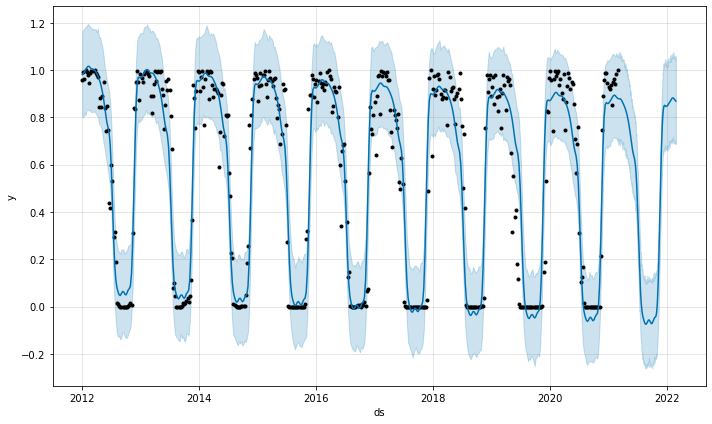

In [11]:
m = Prophet()
m.fit(weekly_prophet)

future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

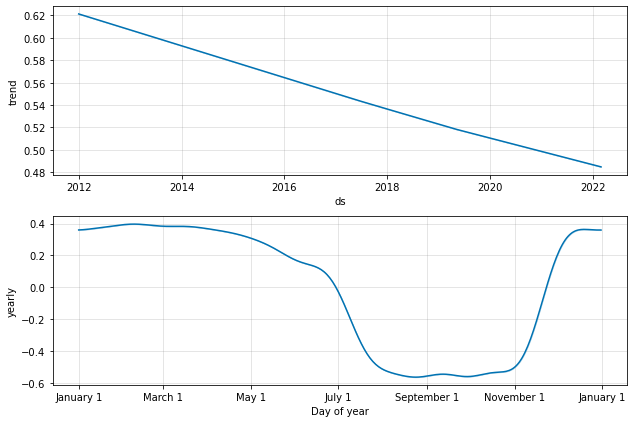

In [12]:
fig2 = m.plot_components(forecast)

### Weekly - capped

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


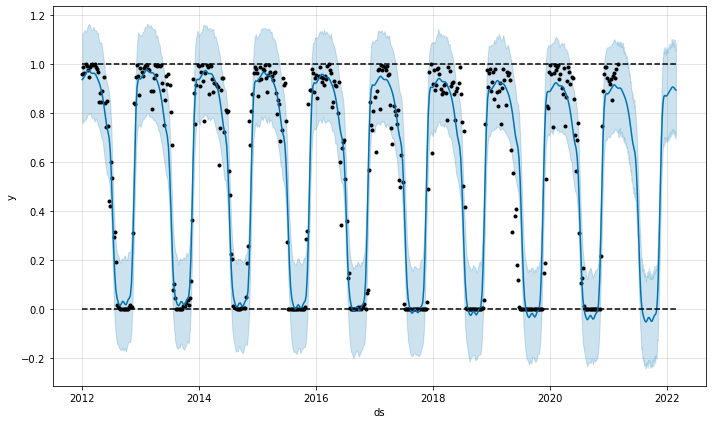

In [13]:
weekly_capped_prophet = weekly_prophet.copy()
weekly_capped_prophet['cap'] = 1.0
weekly_capped_prophet['floor'] = 0.0

m = Prophet(growth='logistic')
m.fit(weekly_capped_prophet)

future = m.make_future_dataframe(periods=365)
future['cap'] = 1.0
future['floor'] = 0.0

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

In [14]:
weekly = weekly_capped_prophet.copy()

### Daily Data

In [15]:
daily = pabrc

In [16]:
daily.reset_index(inplace=True)

In [17]:
daily

index  ICE_C_GDS0_SFC_ave6h
0    2012-01-01 06:00:00                 0.960
1    2012-01-02 06:00:00                 0.965
2    2012-01-03 06:00:00                 0.998
3    2012-01-04 06:00:00                 0.999
4    2012-01-05 06:00:00                 1.000
...                  ...                   ...
3342 2021-02-24 06:00:00                 0.996
3343 2021-02-25 06:00:00                 0.995
3344 2021-02-26 06:00:00                 1.000
3345 2021-02-27 06:00:00                 1.000
3346 2021-02-28 06:00:00                 1.000

[3347 rows x 2 columns]

In [18]:
daily.rename(columns={'index': 'ds', 'ICE_C_GDS0_SFC_ave6h': 'y'}, inplace=True)

In [19]:
daily

ds      y
0    2012-01-01 06:00:00  0.960
1    2012-01-02 06:00:00  0.965
2    2012-01-03 06:00:00  0.998
3    2012-01-04 06:00:00  0.999
4    2012-01-05 06:00:00  1.000
...                  ...    ...
3342 2021-02-24 06:00:00  0.996
3343 2021-02-25 06:00:00  0.995
3344 2021-02-26 06:00:00  1.000
3345 2021-02-27 06:00:00  1.000
3346 2021-02-28 06:00:00  1.000

[3347 rows x 2 columns]

In [20]:
daily['cap'] = 1
daily['floor'] = 0

In [21]:
m_daily = Prophet()
m_daily.fit(daily)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
future = m_daily.make_future_dataframe(periods=365)
future.tail()

ds
3707 2022-02-24 06:00:00
3708 2022-02-25 06:00:00
3709 2022-02-26 06:00:00
3710 2022-02-27 06:00:00
3711 2022-02-28 06:00:00

In [23]:
future['cap'] = 1
future['floor'] = 0
future

ds  cap  floor
0    2012-01-01 06:00:00    1      0
1    2012-01-02 06:00:00    1      0
2    2012-01-03 06:00:00    1      0
3    2012-01-04 06:00:00    1      0
4    2012-01-05 06:00:00    1      0
...                  ...  ...    ...
3707 2022-02-24 06:00:00    1      0
3708 2022-02-25 06:00:00    1      0
3709 2022-02-26 06:00:00    1      0
3710 2022-02-27 06:00:00    1      0
3711 2022-02-28 06:00:00    1      0

[3712 rows x 3 columns]

In [24]:
forecast = m_daily.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
3707 2022-02-24 06:00:00  1.015793    0.820817    1.199137
3708 2022-02-25 06:00:00  1.013452    0.811906    1.199383
3709 2022-02-26 06:00:00  1.020255    0.811183    1.211694
3710 2022-02-27 06:00:00  1.019291    0.824307    1.225251
3711 2022-02-28 06:00:00  1.015080    0.817373    1.200015

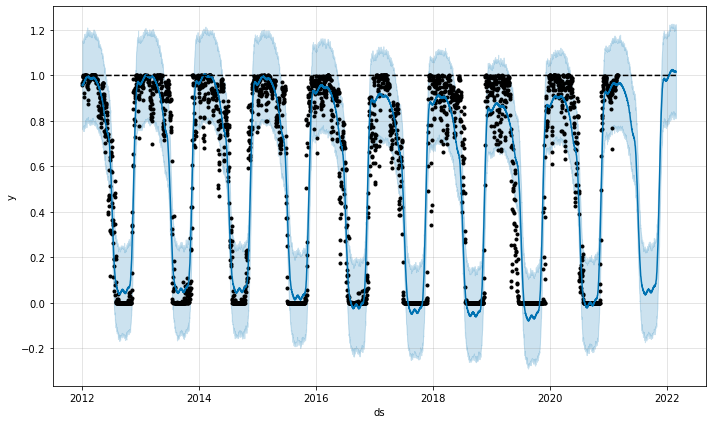

In [25]:
fig1 = m_daily.plot(forecast)

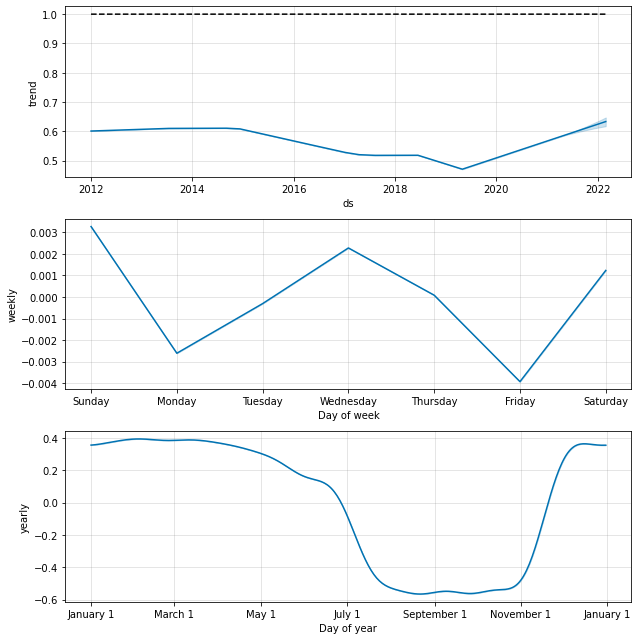

In [26]:
fig2 = m_daily.plot_components(forecast)

### Try with flat growth

In [27]:
m_flat_daily = Prophet(growth='flat')
m_flat_daily.fit(daily)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
future = m_flat_daily.make_future_dataframe(periods=365)
future.tail()

ds
3707 2022-02-24 06:00:00
3708 2022-02-25 06:00:00
3709 2022-02-26 06:00:00
3710 2022-02-27 06:00:00
3711 2022-02-28 06:00:00

In [29]:
future['cap'] = 1
future['floor'] = 0
future

ds  cap  floor
0    2012-01-01 06:00:00    1      0
1    2012-01-02 06:00:00    1      0
2    2012-01-03 06:00:00    1      0
3    2012-01-04 06:00:00    1      0
4    2012-01-05 06:00:00    1      0
...                  ...  ...    ...
3707 2022-02-24 06:00:00    1      0
3708 2022-02-25 06:00:00    1      0
3709 2022-02-26 06:00:00    1      0
3710 2022-02-27 06:00:00    1      0
3711 2022-02-28 06:00:00    1      0

[3712 rows x 3 columns]

In [30]:
forecast = m_flat_daily.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
3707 2022-02-24 06:00:00  0.942623    0.732908    1.140052
3708 2022-02-25 06:00:00  0.939993    0.741393    1.154190
3709 2022-02-26 06:00:00  0.946499    0.731951    1.162458
3710 2022-02-27 06:00:00  0.945320    0.742510    1.158305
3711 2022-02-28 06:00:00  0.940763    0.729493    1.158752

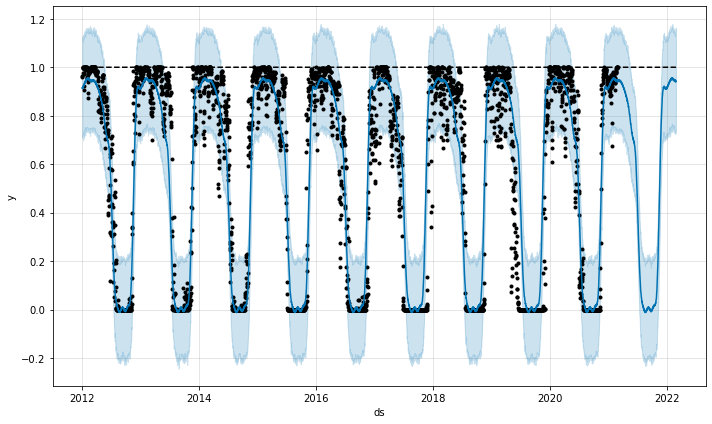

In [31]:
fig1 = m_flat_daily.plot(forecast)

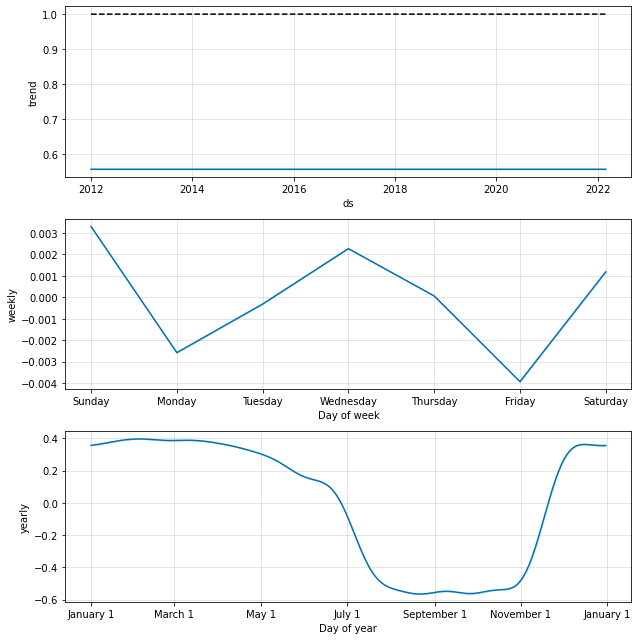

In [32]:
fig2 = m_flat_daily.plot_components(forecast)

### Try with no weekly component

In [33]:
m_daily_noweek = Prophet(weekly_seasonality=False)
m_daily_noweek.fit(daily)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
future = m_daily_noweek.make_future_dataframe(periods=365)
future.tail()

ds
3707 2022-02-24 06:00:00
3708 2022-02-25 06:00:00
3709 2022-02-26 06:00:00
3710 2022-02-27 06:00:00
3711 2022-02-28 06:00:00

In [35]:
future['cap'] = 1
future['floor'] = 0
future

ds  cap  floor
0    2012-01-01 06:00:00    1      0
1    2012-01-02 06:00:00    1      0
2    2012-01-03 06:00:00    1      0
3    2012-01-04 06:00:00    1      0
4    2012-01-05 06:00:00    1      0
...                  ...  ...    ...
3707 2022-02-24 06:00:00    1      0
3708 2022-02-25 06:00:00    1      0
3709 2022-02-26 06:00:00    1      0
3710 2022-02-27 06:00:00    1      0
3711 2022-02-28 06:00:00    1      0

[3712 rows x 3 columns]

In [36]:
forecast = m_daily_noweek.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
3707 2022-02-24 06:00:00  1.021165    0.818532    1.230646
3708 2022-02-25 06:00:00  1.021310    0.837604    1.237520
3709 2022-02-26 06:00:00  1.021537    0.831660    1.214225
3710 2022-02-27 06:00:00  1.021839    0.819548    1.213753
3711 2022-02-28 06:00:00  1.022208    0.830127    1.223351

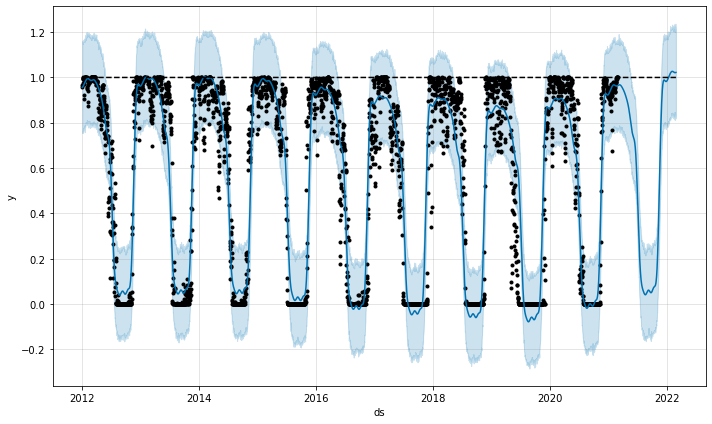

In [37]:
fig1 = m_daily_noweek.plot(forecast)

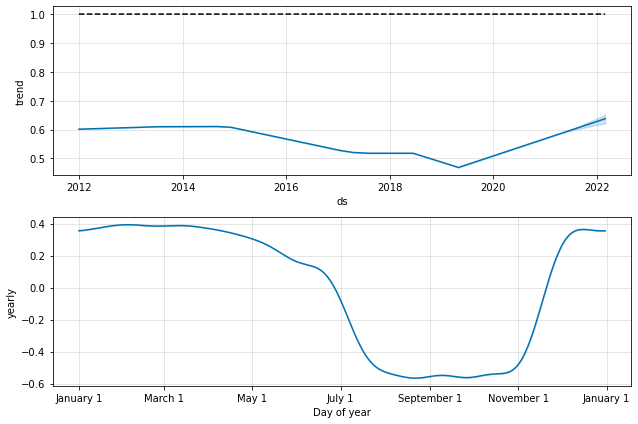

In [38]:
fig2 = m_daily_noweek.plot_components(forecast)

## Build ice-only models specifying args

In [39]:
%%html
<style>
table {float:left}
</style>

### Summary of RMSE metrics for horizon (forecast of 2020 when trained on 2012 - 2019)

| model | mean rmse | max rmse |
|-------|------|--------  |
| a | 0.270681 | 0.435618 |
| b | 0.151186 | 0.263871 |
| c | 0.139086 | 0.276647 |
| d | 0.116431 | 0.232883 |
| e | 0.118750 | 0.247361 |
| f | 0.114659 | 0.229446 |
| g | 0.139625 | 0.279165 |

### Key parameters for ice concentration only model

- growth = 'logistic'.  Ensures model saturates at 0 and 1 which is physicaly correct.
- seasonality_mode = 'multiplicative'. Combined with growth, ensures that trend + season is physically correct.
- Use weekly average values for training. Removes a lot of noise in the signal.
- Smaller effects: change_point = 0.9, n_changepoints=25

### Model A - Yearly seasonablity default check with daily values.

Data notes:
- Daily values with columns of cap and floor
- Forecast of daily values also with cap and floor

Notes:
- Many change points are missed.
- Trend seems wrong as well (I could check).

  0%|          | 0/1 [00:00<?, ?it/s]

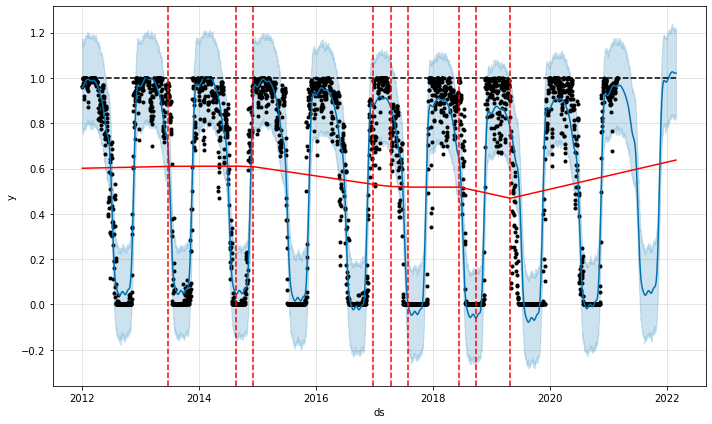

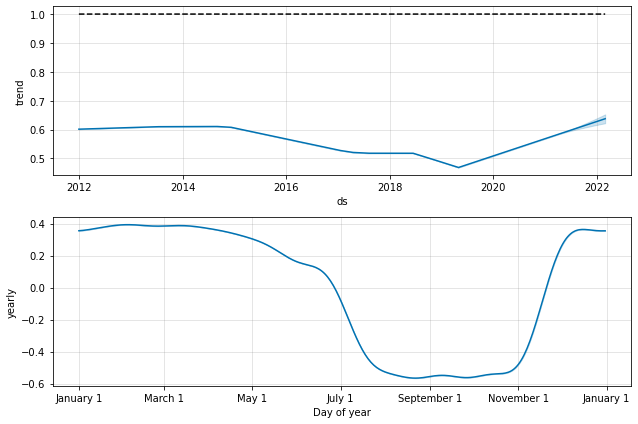

INFO:prophet:Skipping MAPE because y close to 0


count    330.000000
mean       0.270681
std        0.059826
min        0.180514
25%        0.232279
50%        0.251644
75%        0.312642
max        0.435618
Name: rmse, dtype: float64


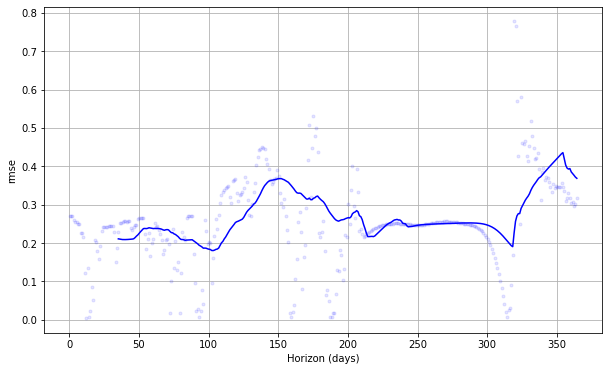

In [40]:
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive'
)
basic.fit(daily)
forecast = basic.predict(future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

### Model B - Yearly seasonability default check with weekly values.

Data notes:
- Weekly values with columns of cap and floor
- Forecast of weekly values also with cap and floor

Notes:
- Many change points are missed.
- Trend is better.
- Negative values

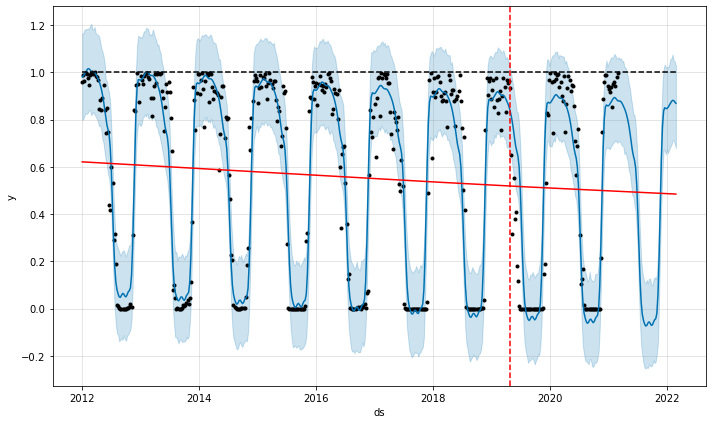

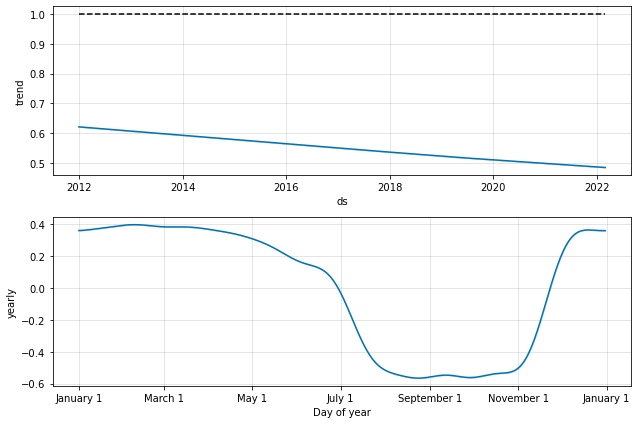

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.151186
std       0.052535
min       0.065178
25%       0.111720
50%       0.138382
75%       0.188058
max       0.263871
Name: rmse, dtype: float64


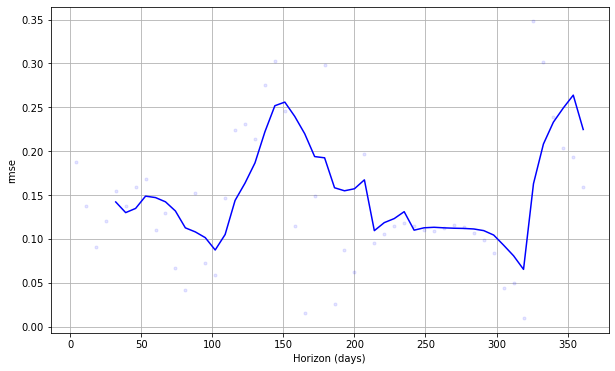

In [41]:
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive'
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)
plt.show()

cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

### Model C - Yearly seasonablity default check with weekly values.

Model notes:
- Multiplicative seasonality

Data notes:
- Weekly values with columns of cap and floor
- Forecast of weekly values also with cap and floor

Notes:
- Many change points are missed
- Trend is better
- Negative values

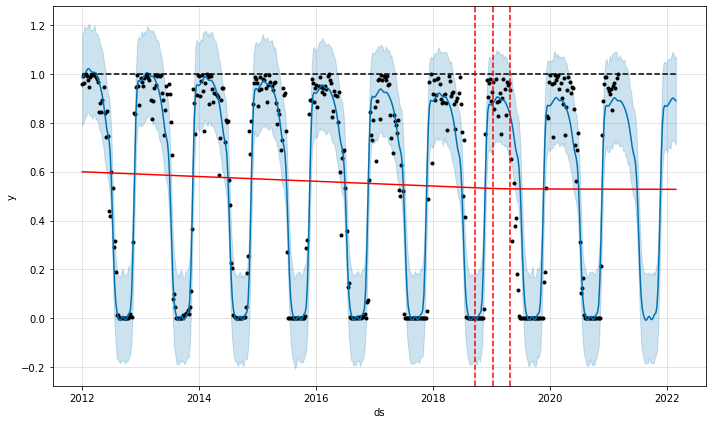

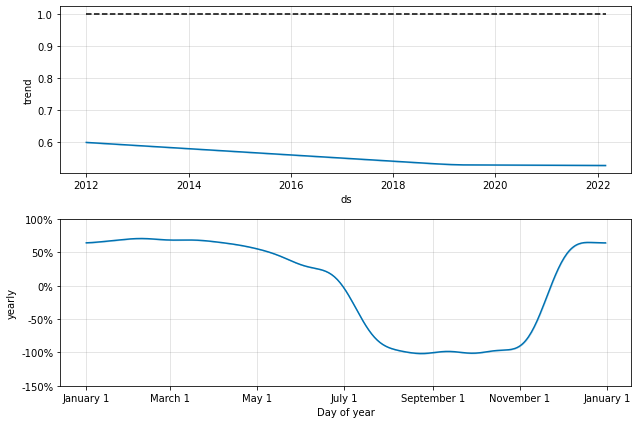

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.139086
std       0.088297
min       0.002266
25%       0.064003
50%       0.157242
75%       0.193960
max       0.276647
Name: rmse, dtype: float64


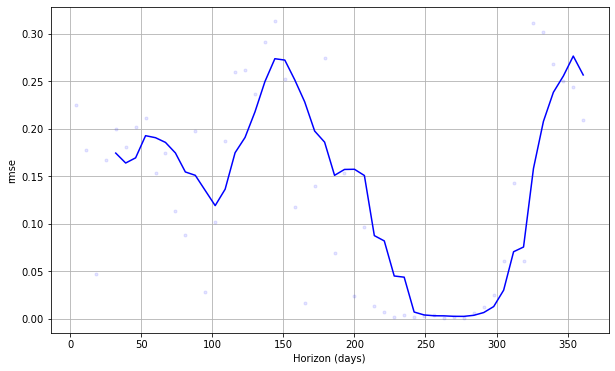

In [42]:
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative'
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()

cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

### Model D - Yearly seasonablity, weekly values, logistic

Model notes:
- Multiplicative seasonality
- logistic model

Data notes:
- Weekly values with columns of cap and floor
- Forecast of weekly values also with cap and floor

Notes:
- Many change points are missed, but much better in early part of time series. Need to explore.
- Trend is better
- Values remain sane, but misses the maximums

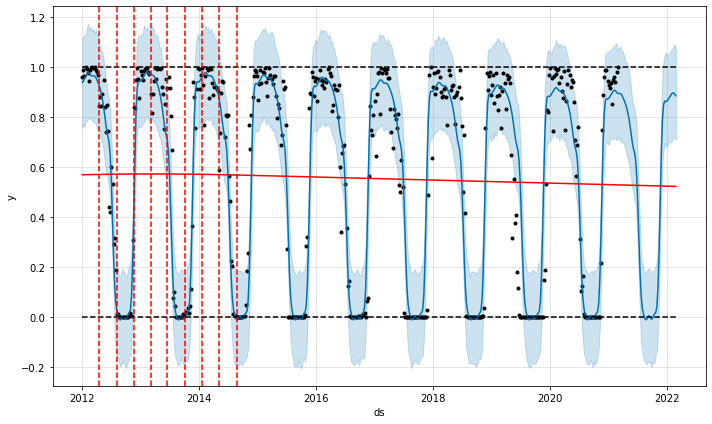

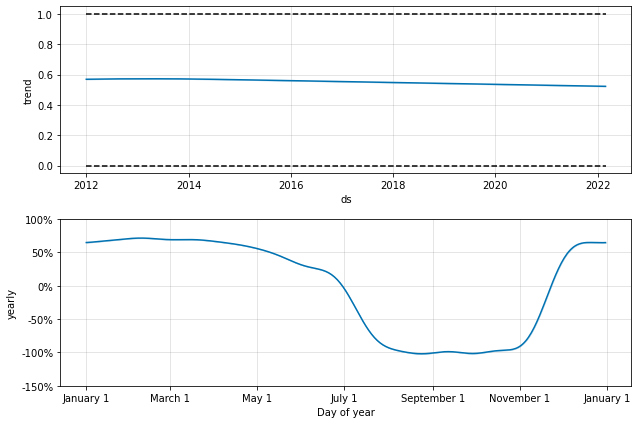

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.116431
std       0.072774
min       0.002344
25%       0.065947
50%       0.132201
75%       0.161057
max       0.232883
Name: rmse, dtype: float64


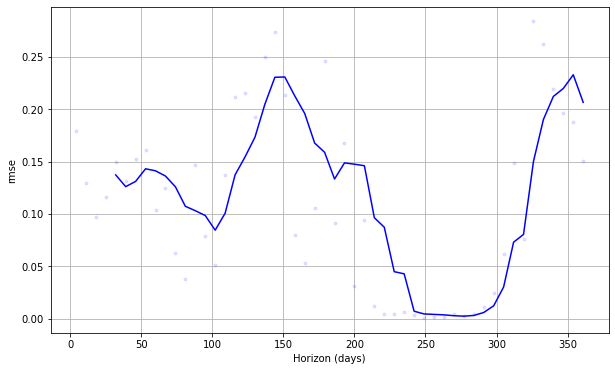

In [43]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative'
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()

cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

### Model E - Yearly seasonablity, weekly values, logistic, add multi-annual seasonality

Model notes:
- Multiplicative seasonality
- logistic model
- tried 2, 3, 4 -annual seasonality with various Fourier orders and prior scales.

Data notes:
- Weekly values with columns of cap and floor
- Forecast of weekly values also with cap and floor

Notes:
- Many change points are missed, but much better in early part of time series. Need to explore.
- Trend is better
- Annual and multi-iannual are more wavey due to Fourier terms. Not as ideal.


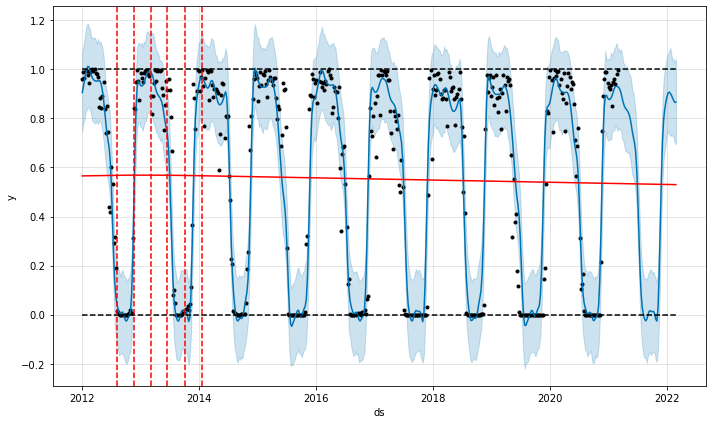

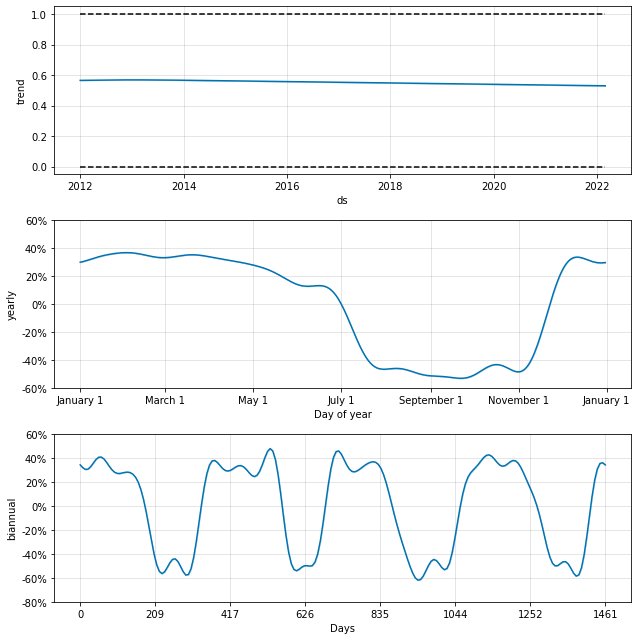

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.118750
std       0.074283
min       0.006961
25%       0.060748
50%       0.121052
75%       0.166250
max       0.247361
Name: rmse, dtype: float64


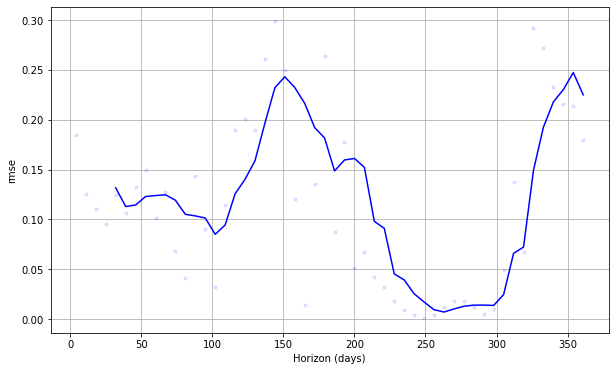

In [87]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative'
).add_seasonality(
    name='biannual',
    period = 365.25 * 4,
    fourier_order=20,  # total guess
    prior_scale=5
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

### Model F - Yearly seasonablity, weekly values, logistic, change_point settings

Model notes:
- Multiplicative seasonality
- logistic model
- Increase percentage of training set used for traning: 0.8 -> 0.9

Data notes:
- Weekly values with columns of cap and floor
- Forecast of weekly values also with cap and floor

Notes:
- Many change points are missed, but much better in early part of time series
- Trend is better
- More change points found and over all seems slightly improved

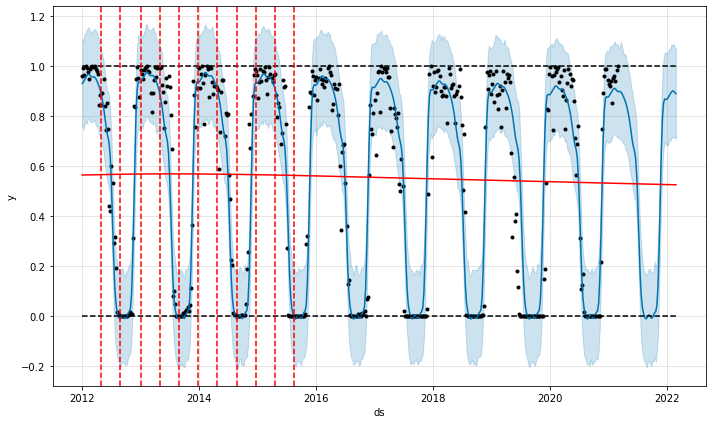

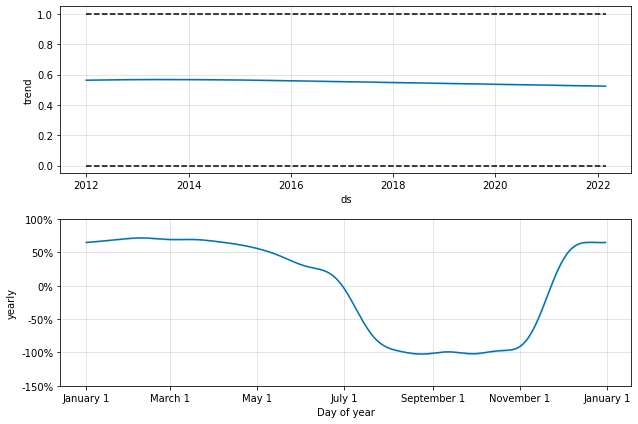

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.114659
std       0.071455
min       0.003507
25%       0.065455
50%       0.129892
75%       0.159120
max       0.229446
Name: rmse, dtype: float64


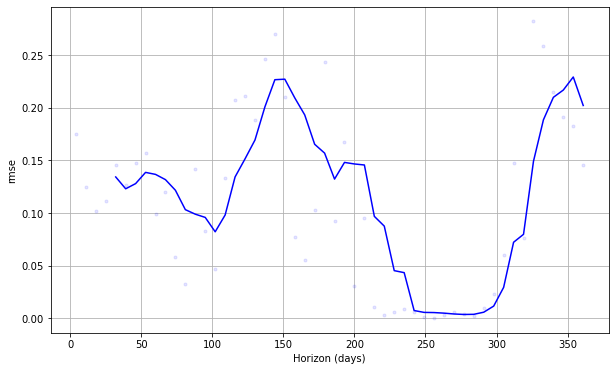

In [88]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

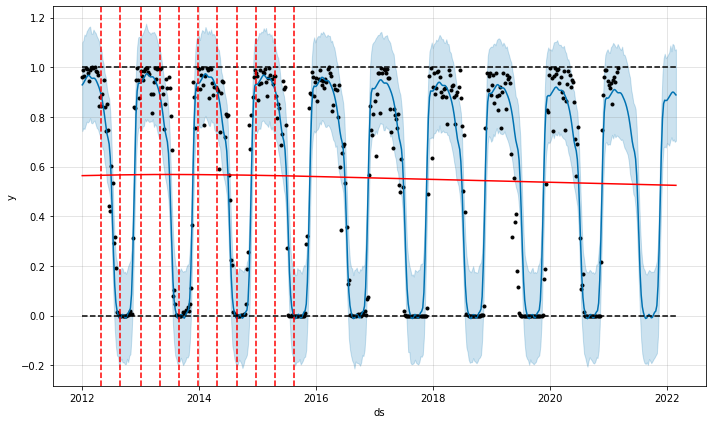

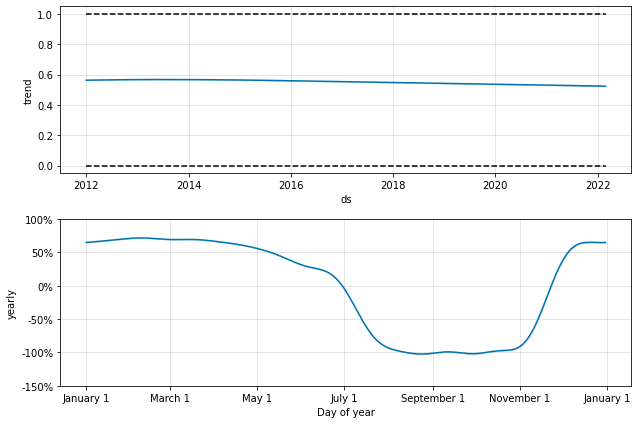

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.114659
std       0.071455
min       0.003507
25%       0.065455
50%       0.129892
75%       0.159120
max       0.229446
Name: rmse, dtype: float64


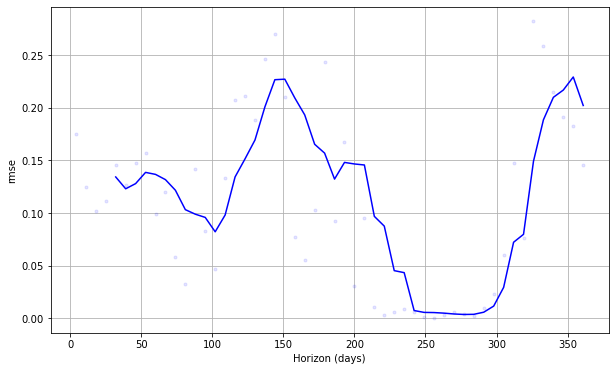

In [89]:
# no difference
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    n_changepoints=25
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

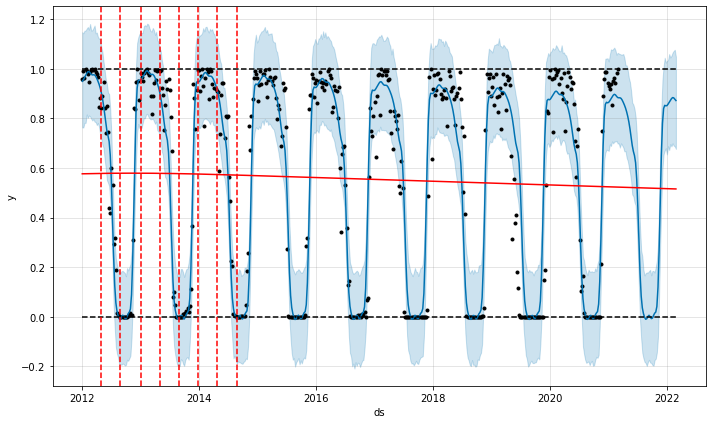

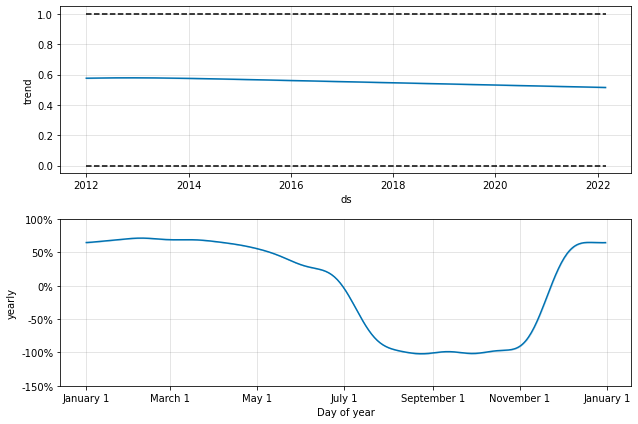

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.126406
std       0.079418
min       0.002021
25%       0.065228
50%       0.147871
75%       0.173077
max       0.251666
Name: rmse, dtype: float64


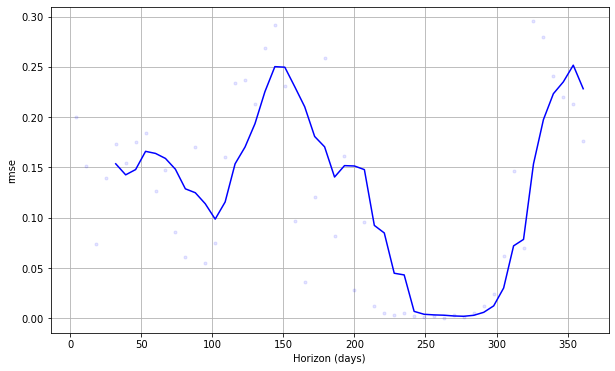

In [90]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    changepoint_prior_scale=0.1
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

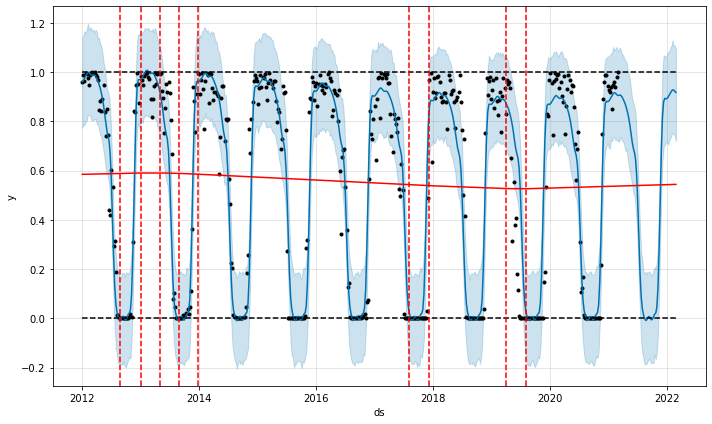

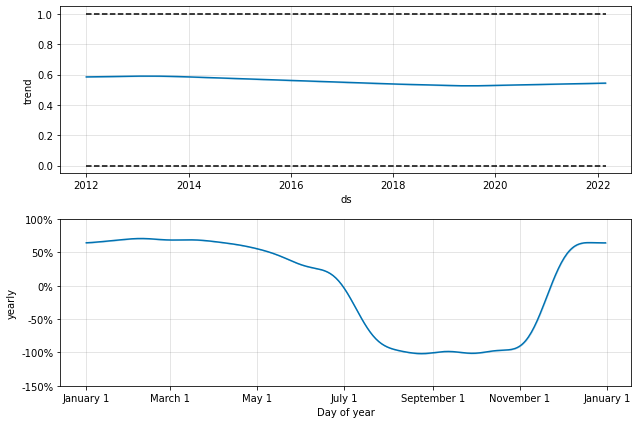

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.145717
std       0.093522
min       0.002028
25%       0.063000
50%       0.162302
75%       0.205214
max       0.292876
Name: rmse, dtype: float64


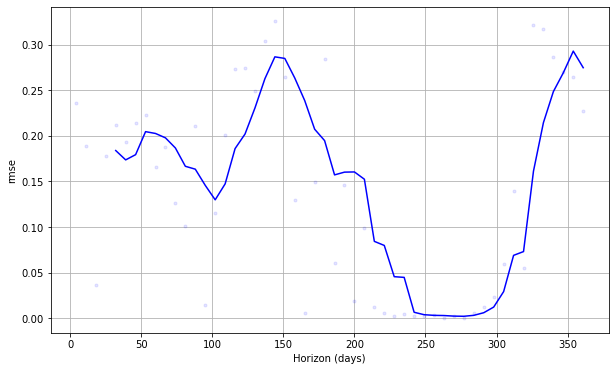

In [91]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    changepoint_prior_scale=0.25
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

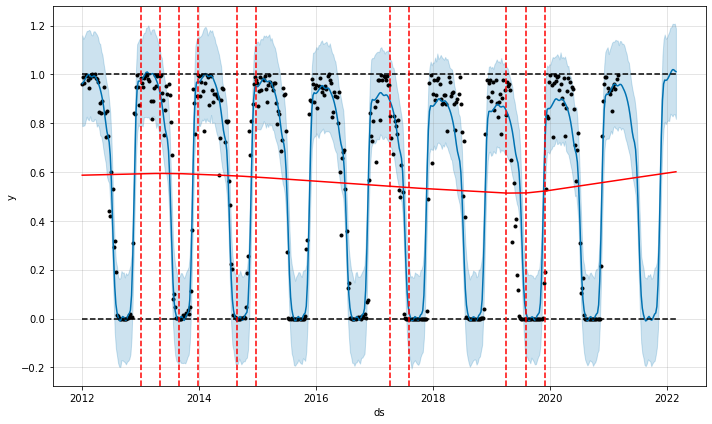

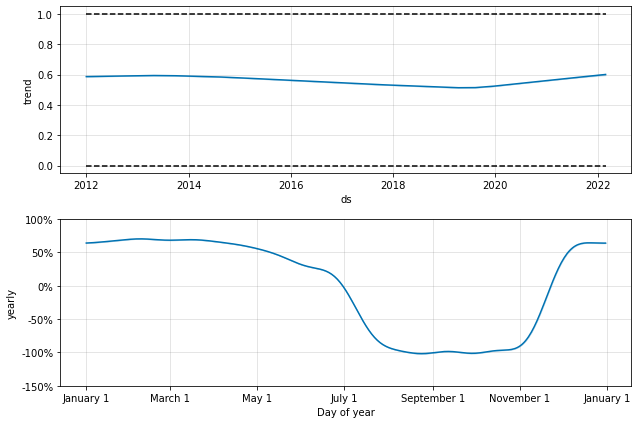

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.201981
std       0.137945
min       0.001670
25%       0.053436
50%       0.250082
75%       0.296630
max       0.423504
Name: rmse, dtype: float64


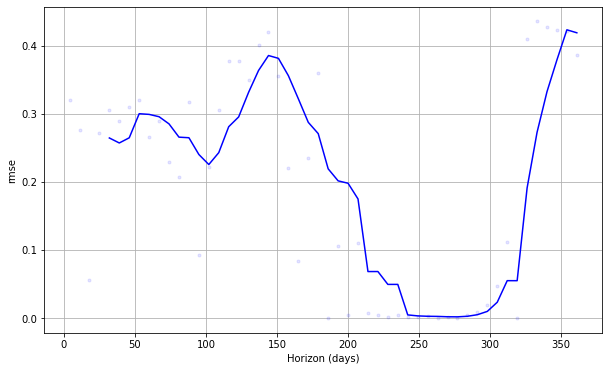

In [92]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    changepoint_prior_scale=0.5
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

### Model G - Yearly seasonablity, weekly values, logistic, change_point (0.9) + seasonality_prior_sacle

Model notes:
- Multiplicative seasonality
- logistic model
- Explore seasonality_prior_scale

Data notes:
- Weekly values with columns of cap and floor
- Forecast of weekly values also with cap and floor

Notes:
- Many change points are missed, but much better in early part of time series
- Trend is better
- More change points found and over all seems slightly improved

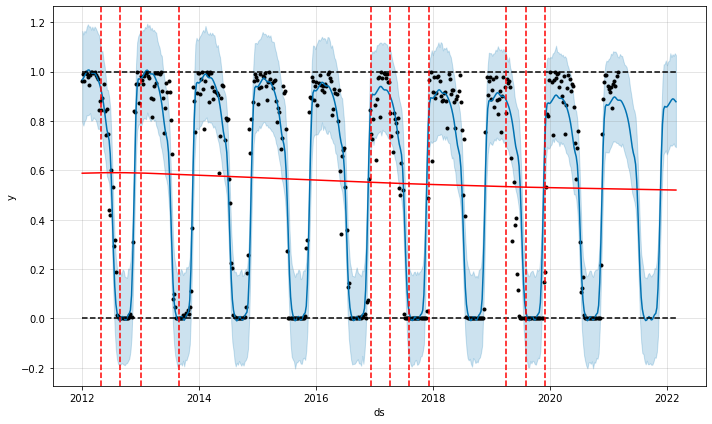

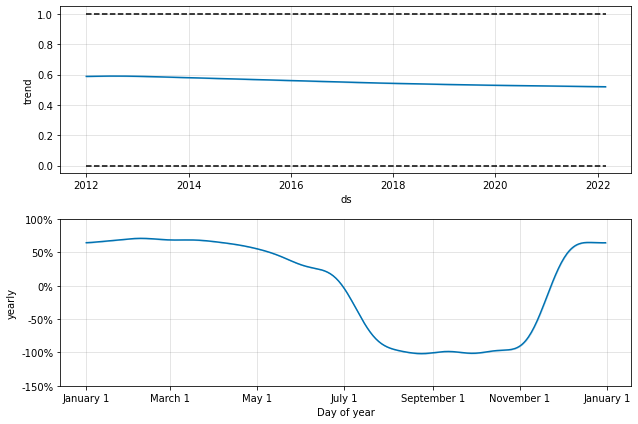

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.139625
std       0.088879
min       0.002091
25%       0.064005
50%       0.157062
75%       0.194445
max       0.279165
Name: rmse, dtype: float64


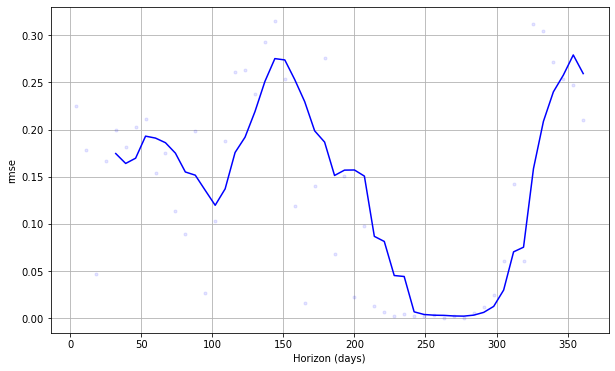

In [93]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    changepoint_prior_scale=0.2,
    seasonality_prior_scale=1
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

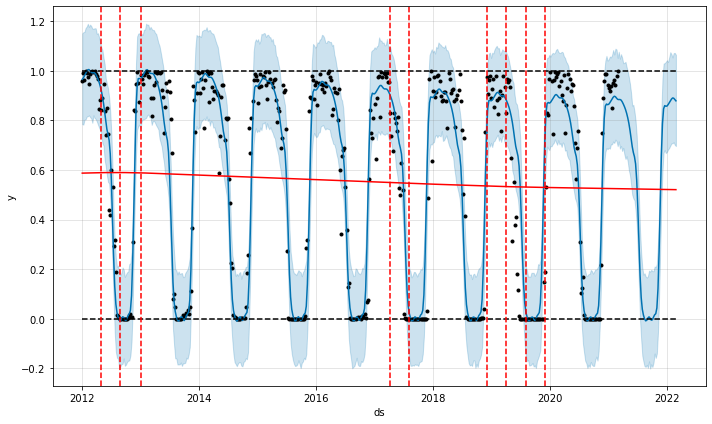

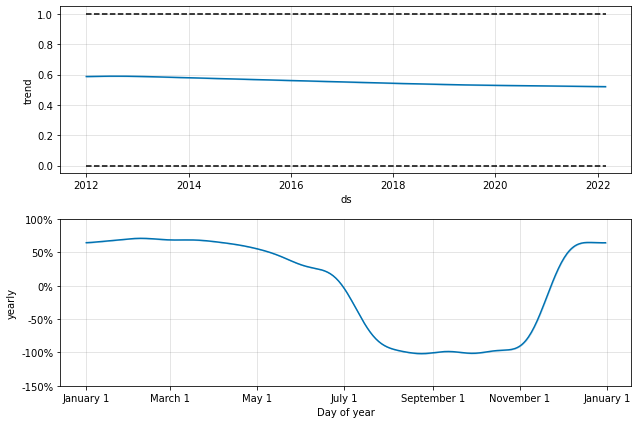

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.139612
std       0.088905
min       0.002025
25%       0.063913
50%       0.157059
75%       0.194437
max       0.279204
Name: rmse, dtype: float64


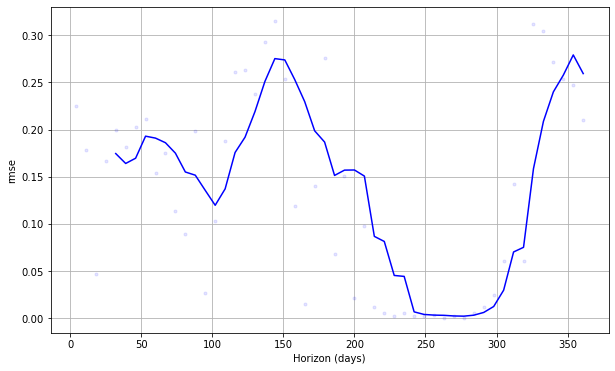

In [94]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    changepoint_prior_scale=0.2,
    seasonality_prior_scale=5
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

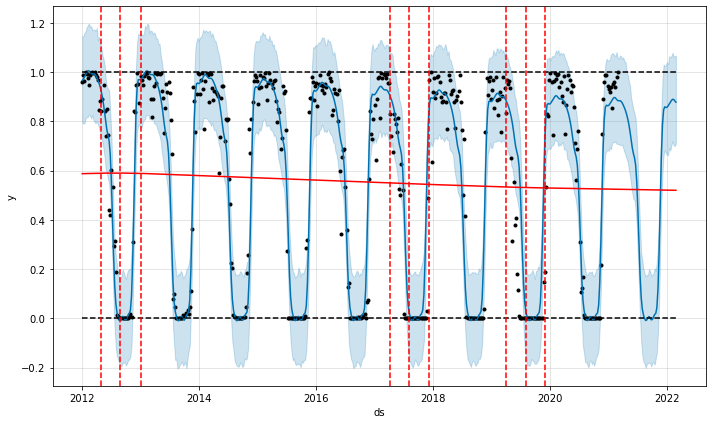

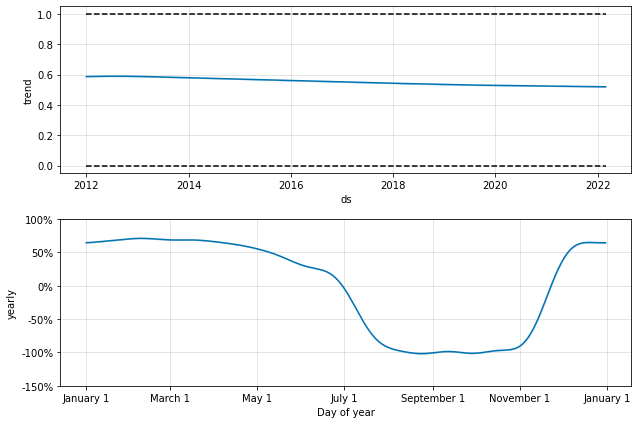

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.139157
std       0.088522
min       0.002096
25%       0.064076
50%       0.156842
75%       0.193614
max       0.278093
Name: rmse, dtype: float64


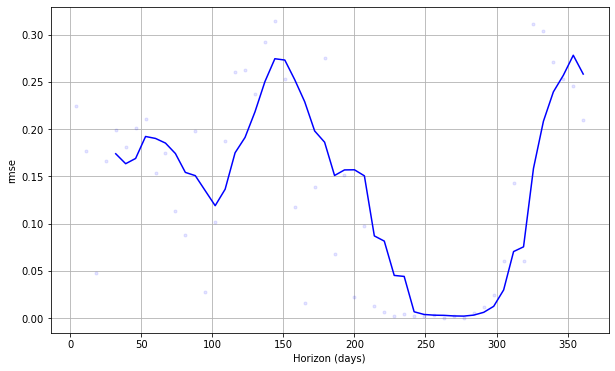

In [95]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    changepoint_prior_scale=0.2,
    seasonality_prior_scale=20
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

## Build models with additional variables

### Load additional variables

Oh yeah, atmosphere is 2012 - present.  But, ocean is only 2019 - present.  Shit.

It seems quite likely that thickness is correlated with concentration, so there may be an opportunity to create another model to represent thickness.  That can then be added in.

In [45]:
variables = {
    'atm_temp.nc': 'POT_GDS0_DBSL_ave6h', 
    'ice_thk.nc': 'ICETK_GDS0_SFC_ave6h',
    'temp.nc': 'TMP_GDS0_SFC_ave6h'
}

var_dfs = []
for fname, var in variables.items():
    var_dfs.append(load_data_local(f'station-data/PABRC-{fname}', var))
    
var_df = pd.concat(var_dfs)  
weekly_df = var_df.resample('W').mean()

In [46]:
variables = {
    'atm_temp.nc': 'POT_GDS0_DBSL_ave6h', 
}

var_dfs = []
for fname, var in variables.items():
    var_dfs.append(load_data_local(f'station-data/PABRC-{fname}', var))
    
var_df = pd.concat(var_dfs)  
weekly_df = var_df.resample('W').mean()
weekly_df

POT_GDS0_DBSL_ave6h
2012-01-01           271.549988
2012-01-08           271.582855
2012-01-15           271.525726
2012-01-22           271.537140
2012-01-29           271.507141
...                         ...
2021-01-31           271.524292
2021-02-07           271.538574
2021-02-14           271.518555
2021-02-21           271.547150
2021-02-28           271.579987

[479 rows x 1 columns]

### Add air temp to ice concentration

Model 2C is the best thus far.

In [47]:
weekly['air-temp'] = weekly_df.values

In [48]:
weekly

ds         y  cap  floor    air-temp
0   2012-01-01  0.960000  1.0    0.0  271.549988
1   2012-01-08  0.989714  1.0    0.0  271.582855
2   2012-01-15  0.963429  1.0    0.0  271.525726
3   2012-01-22  0.998571  1.0    0.0  271.537140
4   2012-01-29  0.991714  1.0    0.0  271.507141
..         ...       ...  ...    ...         ...
474 2021-01-31  0.949857  1.0    0.0  271.524292
475 2021-02-07  0.961429  1.0    0.0  271.538574
476 2021-02-14  0.941286  1.0    0.0  271.518555
477 2021-02-21  0.981571  1.0    0.0  271.547150
478 2021-02-28  0.998714  1.0    0.0  271.579987

[479 rows x 5 columns]

#### Model 2A - Model F + Air Temp

Model notes:
- Same as Model F
- Add air-temp as additional multiplicatibe regressor

Data notes:
- Same as Model F
- Add air-temp.  Air temp for forecast is just copied from last year.  Could create model for this.

Notes:
- Physically unrealistic data (negative values).
- Max error improved, but overall model is worse than Model F.

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:>

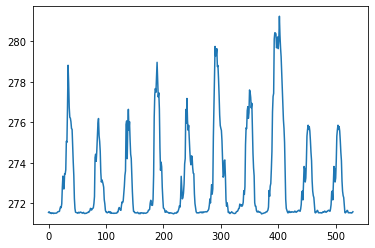

In [167]:
# Same model as Model F
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
# Add air temp as a regressor
basic.add_regressor('air-temp')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp

# seems wrong and bad, but good to get method down.
week_future['air-temp'].plot()

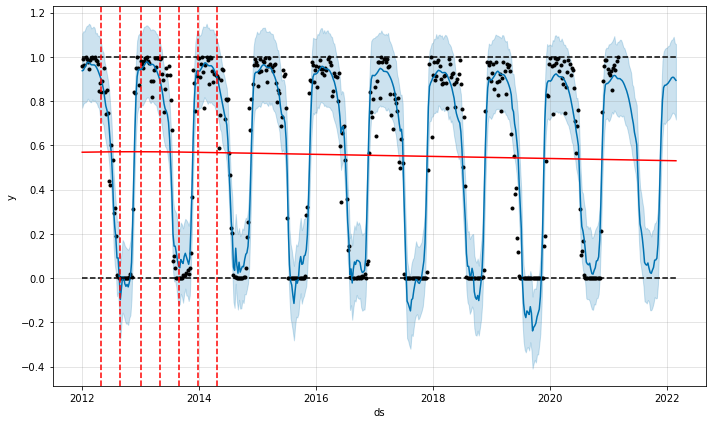

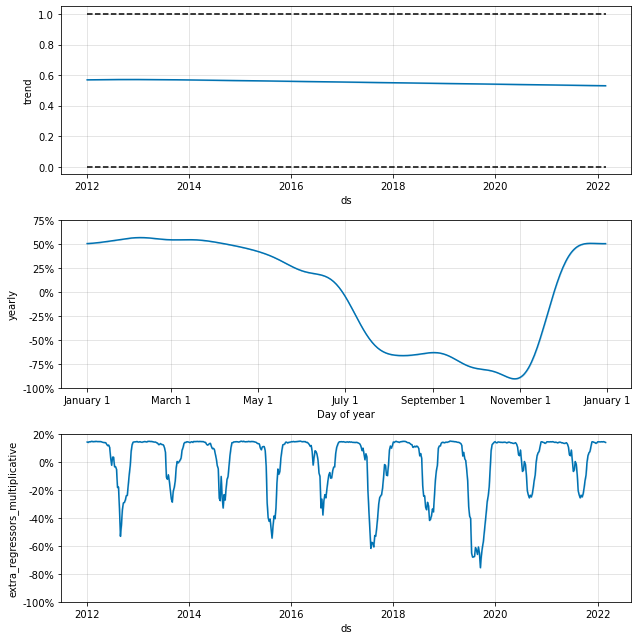

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.127857
std       0.048172
min       0.033557
25%       0.094963
50%       0.128074
75%       0.155130
max       0.212101
Name: rmse, dtype: float64


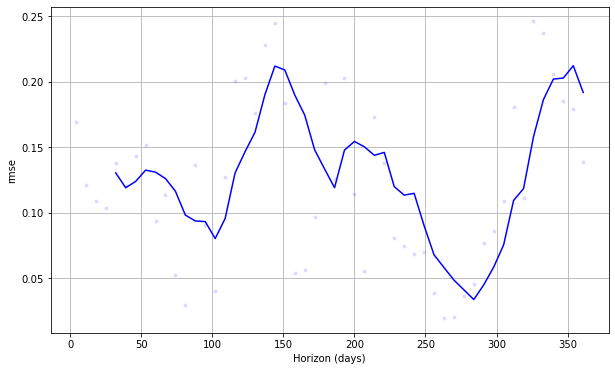

In [168]:
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

#### Model 2B - Model F + Air Temp (additive)

Model notes:
- Same as Model F
- Add air-temp as additional multiplicatibe regressor

Data notes:
- Same as Model F
- Add air-temp.  Air temp for forecast is just copied from last year.  Could create model for this.

Notes:
- Physically unrealistic data (negative values).
- Max error improved than 2A, but overall model is worse than Model F.

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


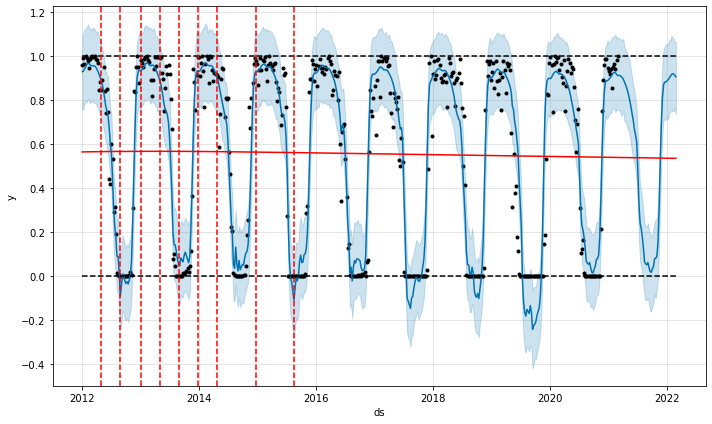

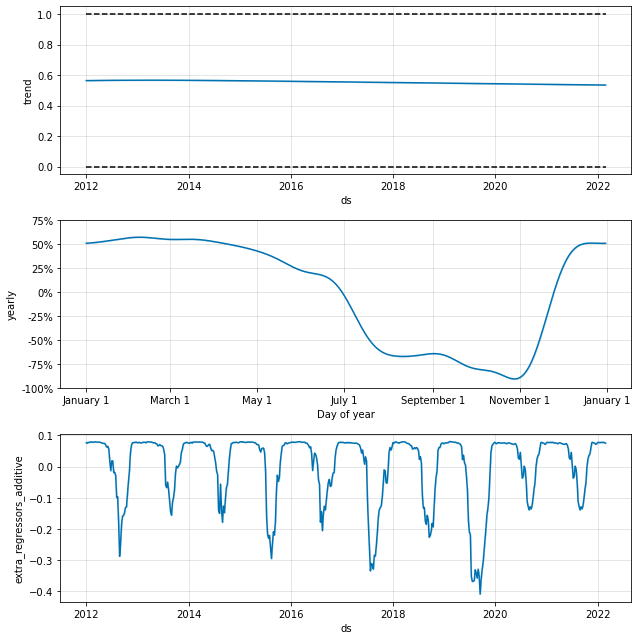

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.118742
std       0.047185
min       0.027372
25%       0.084570
50%       0.115334
75%       0.148956
max       0.196578
Name: rmse, dtype: float64


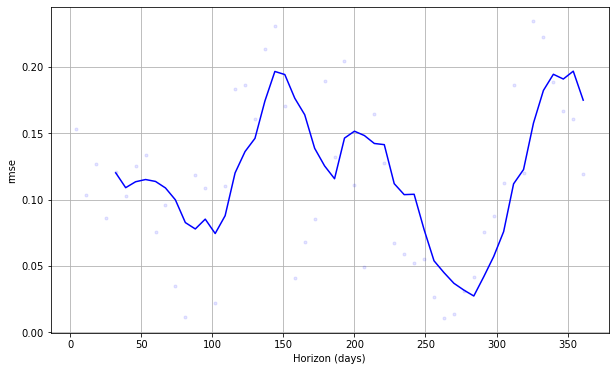

In [171]:
# Same model as Model F
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
# Add air temp as a regressor
basic.add_regressor('air-temp', mode='additive')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

#### Model 2C - Model F + Air Temp (multiplicative + prior_scale)

Model notes:
- Same as Model F
- Add air-temp as additional multiplicatibe regressor

Data notes:
- Same as Model F
- Add air-temp.  Air temp for forecast is just copied from last year.  Could create model for this.

Notes:
- Physically unrealistic data (negative values).
- Max error improved than 2A, but overall model is worse than Model F.

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


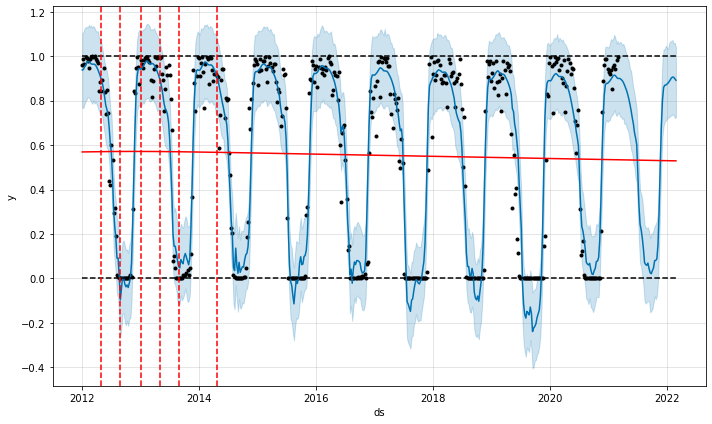

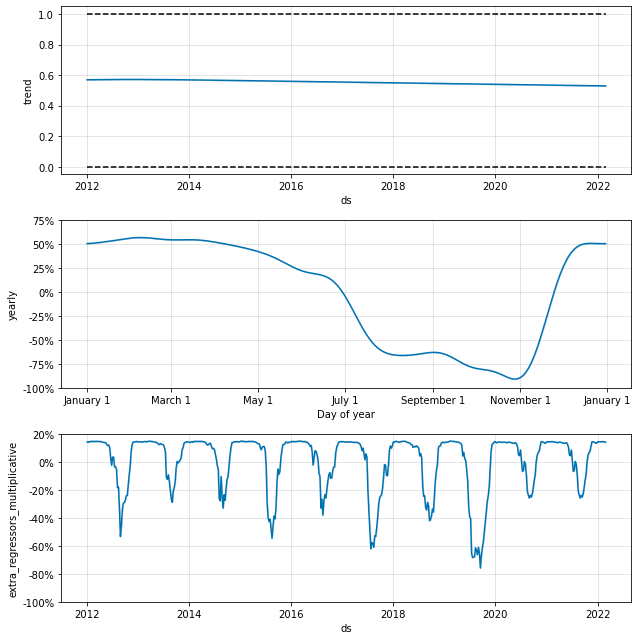

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.127672
std       0.048155
min       0.033338
25%       0.094799
50%       0.127867
75%       0.155026
max       0.211775
Name: rmse, dtype: float64


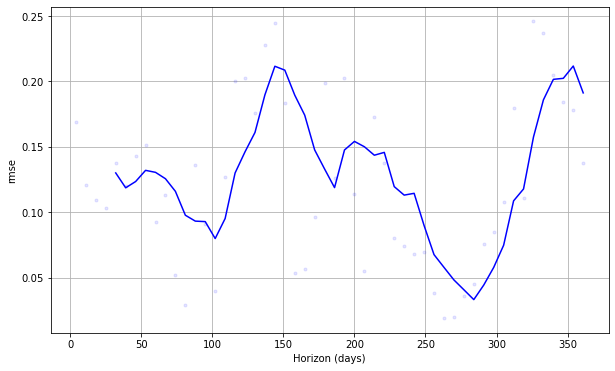

In [173]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
# Add air temp as a regressor
basic.add_regressor('air-temp', prior_scale=1)
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

#### [Best] Model 2C - Model F + Air Temp (multiplicative + don't normalize)

Model notes:
- Same as Model F
- Add air-temp as additional multiplicatibe regressor

Data notes:
- Same as Model F
- Add air-temp.  Air temp for forecast is just copied from last year.  Could create model for this.

Notes:
- Better model.
- Max error and mean, better than Model F
- Trend seems wrong.

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


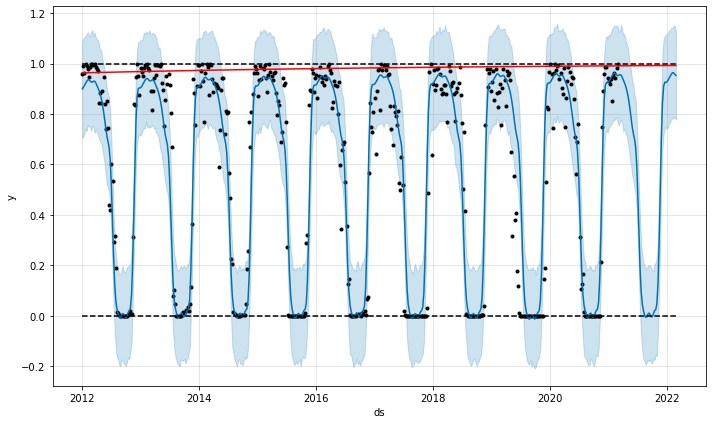

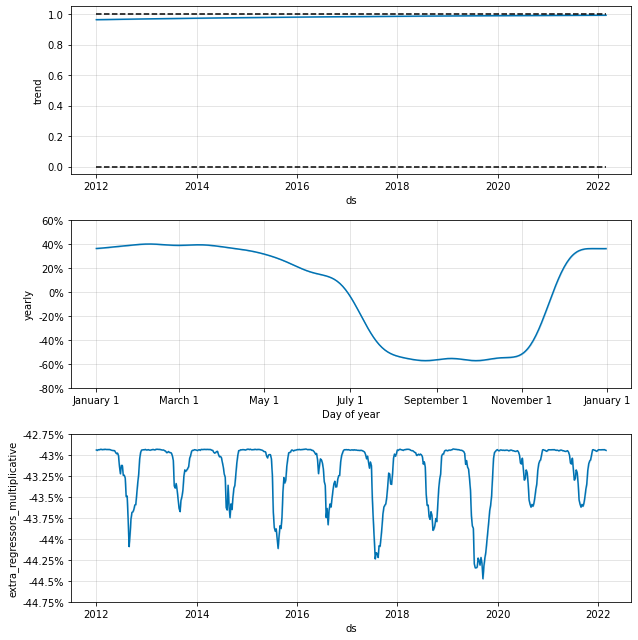

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.082880
std       0.051621
min       0.004134
25%       0.033756
50%       0.101720
75%       0.121853
max       0.162995
Name: rmse, dtype: float64


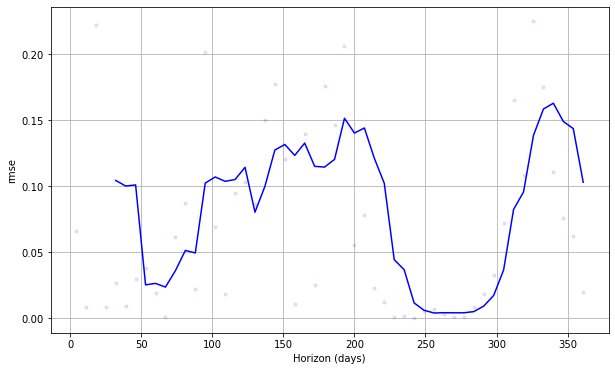

In [176]:
# Same model as Model F
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
# Add air temp as a regressor
basic.add_regressor('air-temp', standardize=False)
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

### Build ice thickness model to use as additional regressor for funsies  - nah.

#### Load ice thickness

In [185]:
variables = {
    'ice_thk.nc': 'ICETK_GDS0_SFC_ave6h',
}

ice_thickness = load_data_local(f'station-data/PABRC-ice_thk.nc', 'ICETK_GDS0_SFC_ave6h')
    
ice_weekly = ice_thickness.resample('W').mean()

<AxesSubplot:>

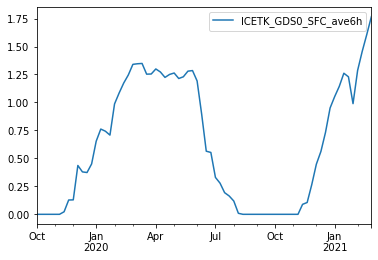

In [187]:
ice_weekly.plot()

In [190]:
# subset to a single year
len(ice_weekly.loc['2020-01-01': '2021-01-01'])

52

### Build air temp model to use in forecast of ice concentration

In [203]:
# Make df
weekly_air = pd.DataFrame(
    {
        'ds': weekly['ds'],
        'y': weekly['air-temp']
    }
)
weekly_air

ds           y
0   2012-01-01  271.549988
1   2012-01-08  271.582855
2   2012-01-15  271.525726
3   2012-01-22  271.537140
4   2012-01-29  271.507141
..         ...         ...
474 2021-01-31  271.524292
475 2021-02-07  271.538574
476 2021-02-14  271.518555
477 2021-02-21  271.547150
478 2021-02-28  271.579987

[479 rows x 2 columns]

#### Model 3A - Linear air model, multiplicative seasonality

This seems to be the best.

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


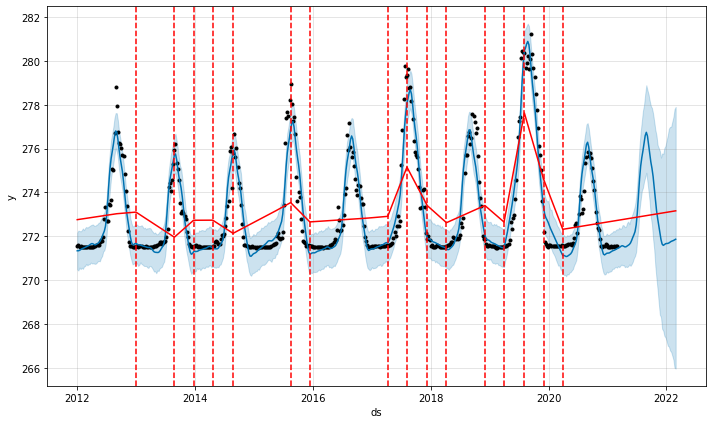

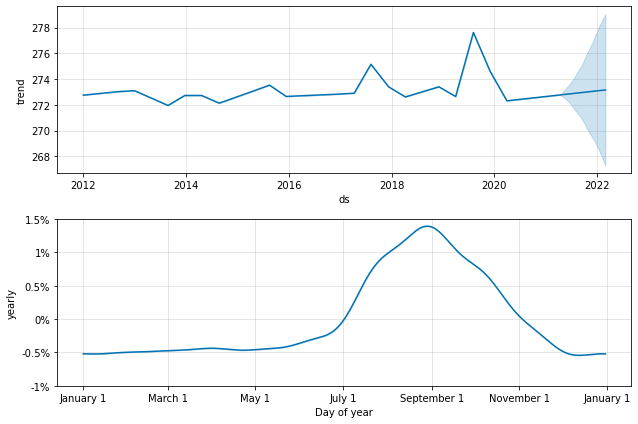

  0%|          | 0/1 [00:00<?, ?it/s]

count    48.000000
mean      4.922402
std       1.431519
min       2.900523
25%       3.497496
50%       4.999286
75%       6.096615
max       7.489760
Name: rmse, dtype: float64


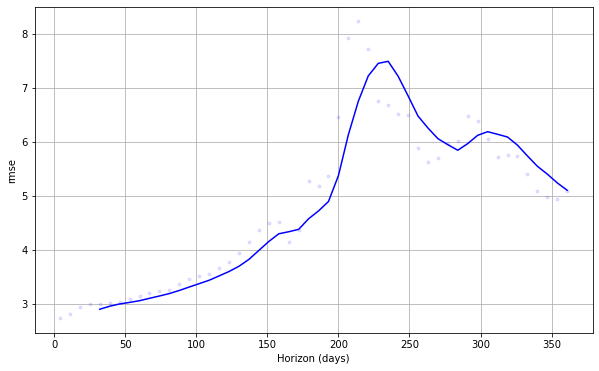

In [204]:
# Same model as Model F
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.fit(weekly_air)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

#### Model 3B - Linear air model, additive seasonality

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


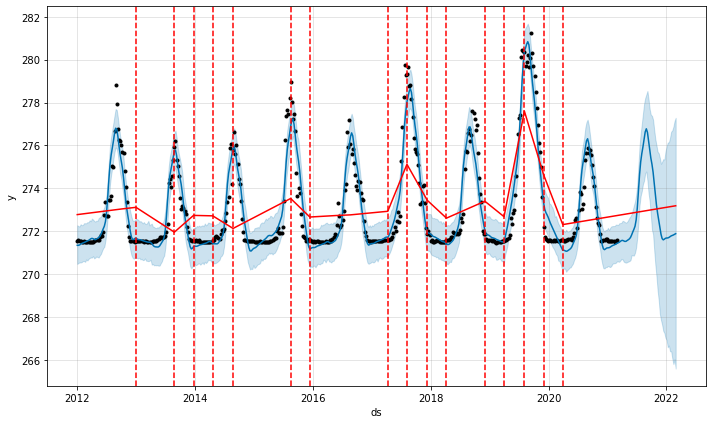

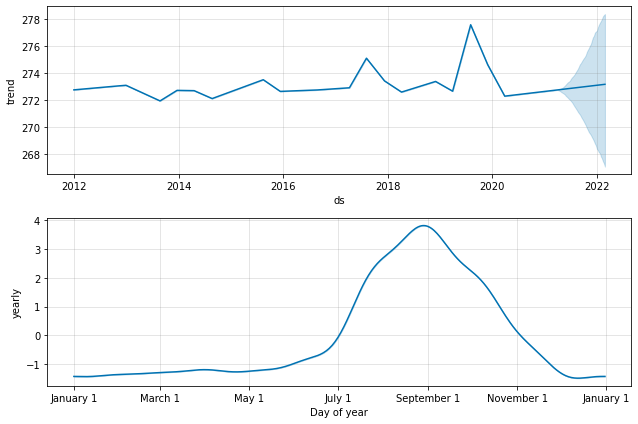

  0%|          | 0/1 [00:00<?, ?it/s]

count    48.000000
mean      4.919928
std       1.398185
min       2.932898
25%       3.524743
50%       5.022811
75%       6.090623
max       7.414306
Name: rmse, dtype: float64


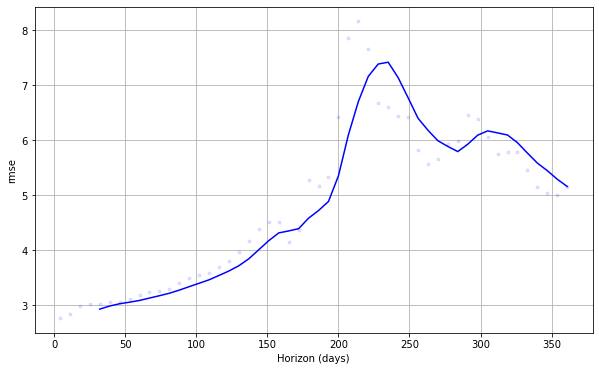

In [206]:
# Same model as Model F
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    changepoint_range=0.9
)
basic.fit(weekly_air)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

#### Model 3C - Linear air model, additive seasonality, changepoint_prior_scale

Notes:
- Default is 0.05
- Small values permit less change points (probably good in this case, and all?)
- Large values permit more change points
- changepoint_prior_scale=0.01 is a good value

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


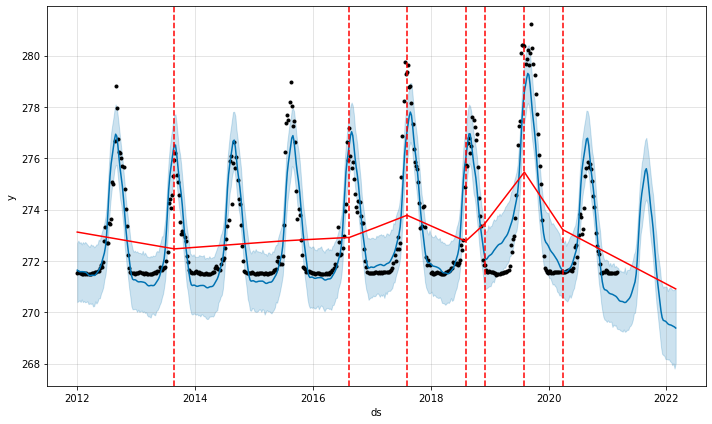

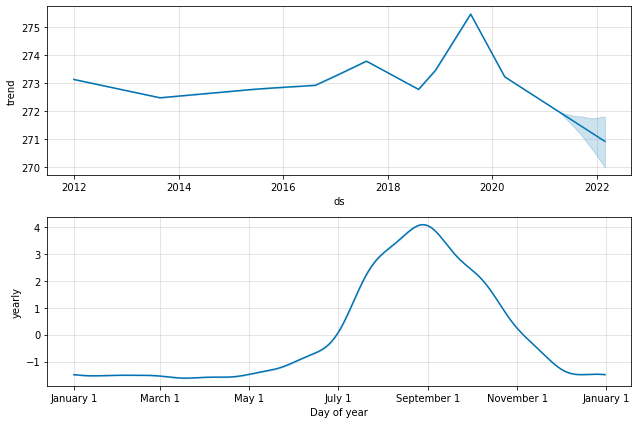

  0%|          | 0/1 [00:00<?, ?it/s]

count    48.000000
mean      4.937250
std       1.215919
min       3.192887
25%       3.741046
50%       4.972637
75%       5.931481
max       7.119392
Name: rmse, dtype: float64


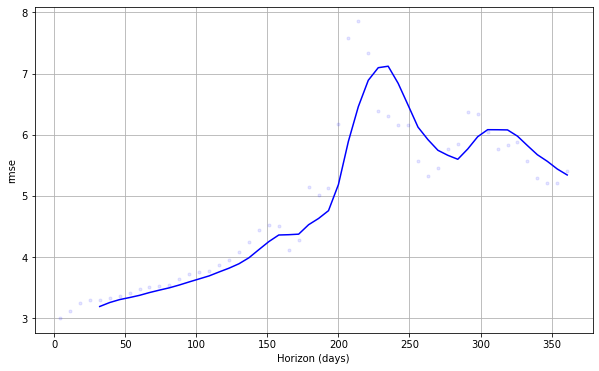

In [210]:
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    changepoint_range=0.9,
    changepoint_prior_scale=0.01
)
basic.fit(weekly_air)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


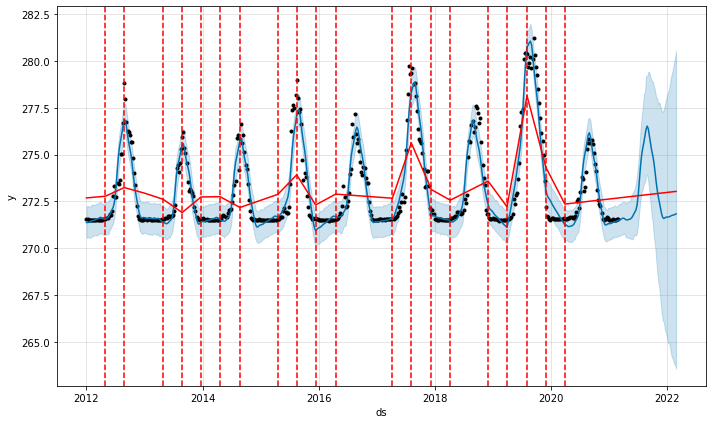

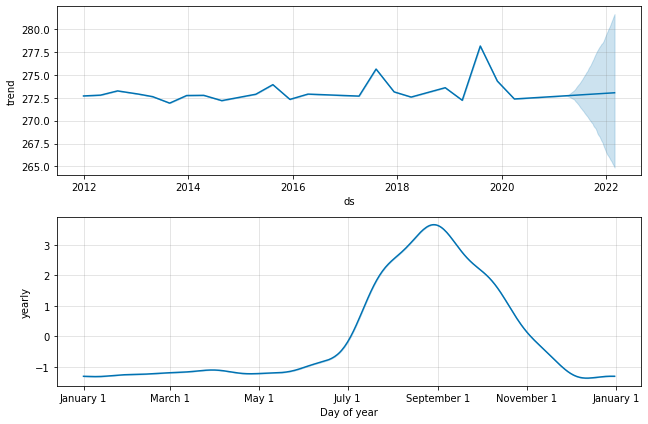

  0%|          | 0/1 [00:00<?, ?it/s]

count    48.000000
mean      3.919241
std       1.780840
min       1.624876
25%       2.100151
50%       3.863320
75%       5.273951
max       7.167745
Name: rmse, dtype: float64


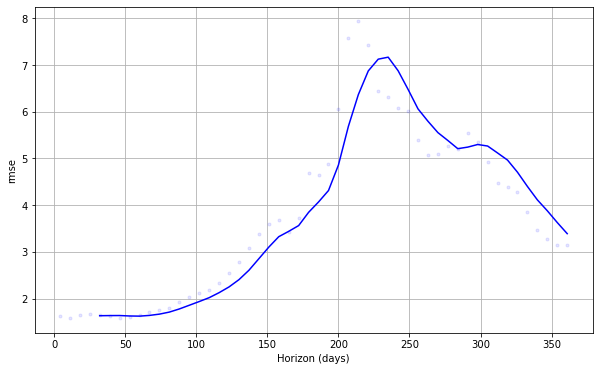

In [209]:
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    changepoint_range=0.9,
    changepoint_prior_scale=0.1
)
basic.fit(weekly_air)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


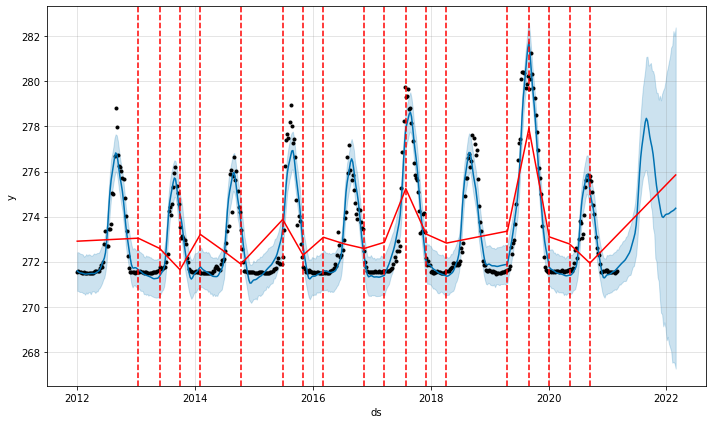

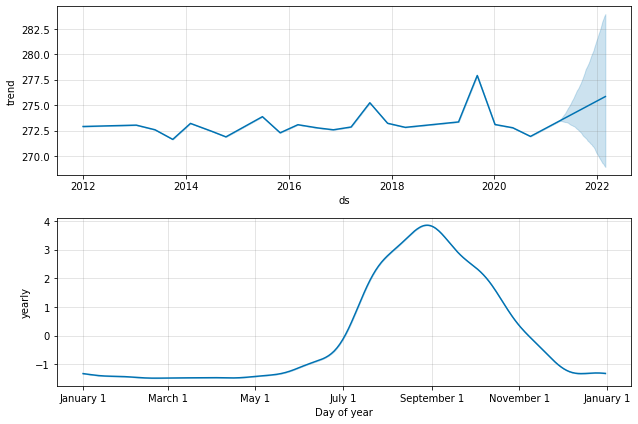

  0%|          | 0/1 [00:00<?, ?it/s]

count    48.000000
mean      4.240761
std       2.434604
min       0.297216
25%       2.502302
50%       3.858564
75%       6.366141
max       9.294010
Name: rmse, dtype: float64


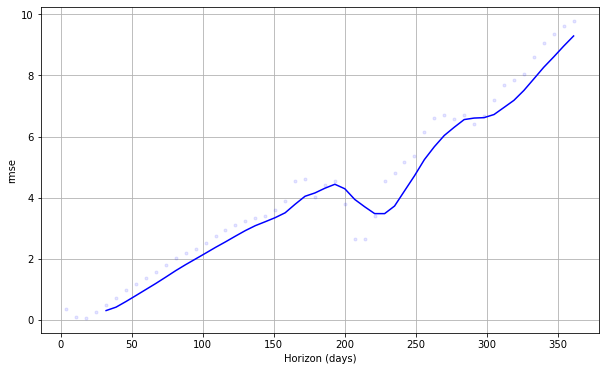

In [218]:
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    changepoint_range=0.95,
    changepoint_prior_scale=0.1
)
basic.fit(weekly_air)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


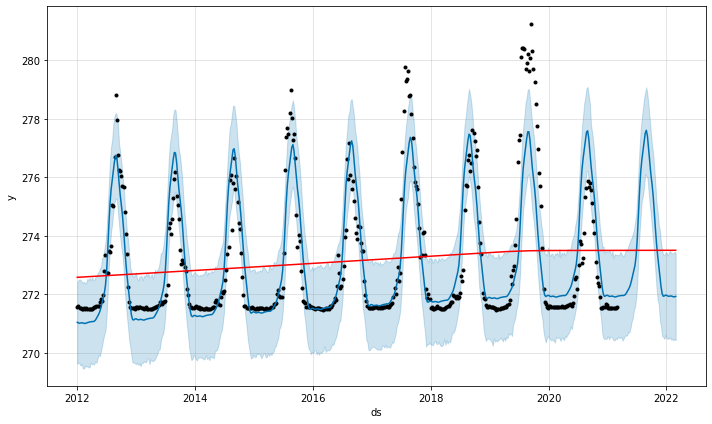

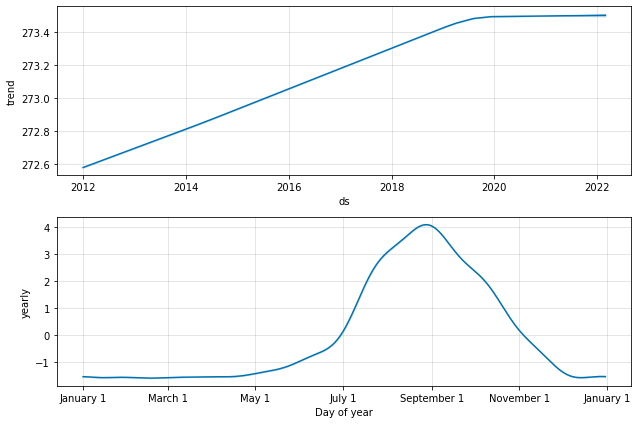

  0%|          | 0/1 [00:00<?, ?it/s]

count    48.000000
mean      2.460226
std       0.847098
min       1.584593
25%       1.681626
50%       2.185589
75%       2.961922
max       4.449935
Name: rmse, dtype: float64


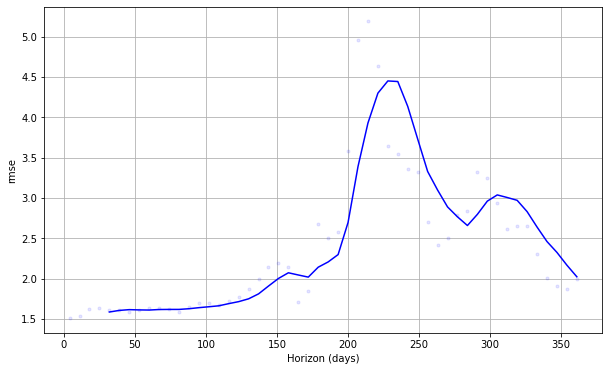

In [211]:
# Same model as Model F
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    changepoint_range=0.9,
    changepoint_prior_scale=0.001
)
basic.fit(weekly_air)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


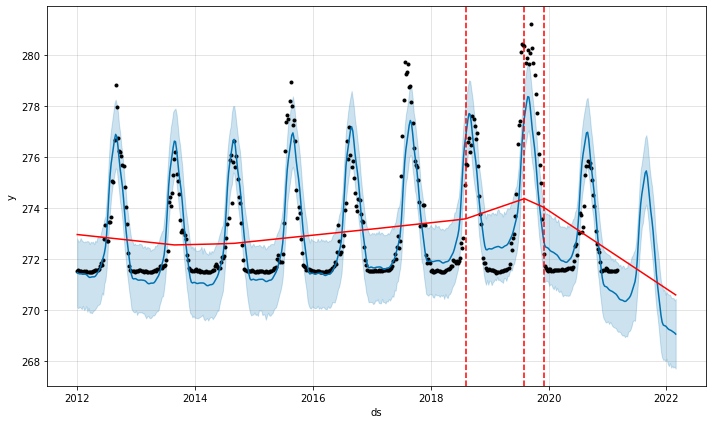

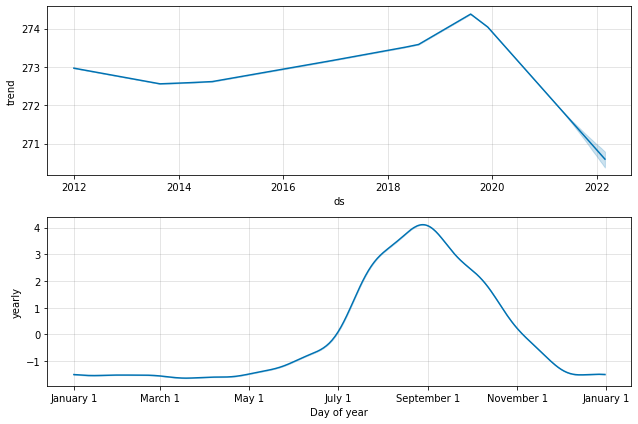

  0%|          | 0/1 [00:00<?, ?it/s]

count    48.000000
mean      4.265621
std       1.086587
min       2.795122
25%       3.201857
50%       4.249378
75%       5.132279
max       6.380608
Name: rmse, dtype: float64


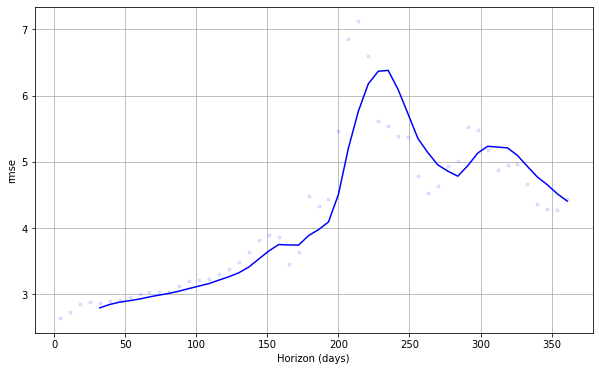

In [212]:
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    changepoint_range=0.9,
    changepoint_prior_scale=0.005
)
basic.fit(weekly_air)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

In [213]:
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2012-01-01  272.966667  270.111939  272.805656   272.966667   272.966667   
1   2012-01-08  272.961919  270.073074  272.691905   272.961919   272.961919   
2   2012-01-15  272.957171  270.135182  272.703336   272.957171   272.957171   
3   2012-01-22  272.952423  270.092650  272.828623   272.952423   272.952423   
4   2012-01-29  272.947675  270.040375  272.737968   272.947675   272.947675   
..         ...         ...         ...         ...          ...          ...   
526 2022-01-30  270.714287  267.738402  270.491468   270.519489   270.890460   
527 2022-02-06  270.684866  267.807013  270.465736   270.487098   270.865368   
528 2022-02-13  270.655444  267.743785  270.476078   270.449373   270.840272   
529 2022-02-20  270.626022  267.776596  270.383914   270.411680   270.815177   
530 2022-02-27  270.596601  267.703678  270.433537   270.377731   270.790964   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0         -1.496065             -1.496065             -1.496065 -1.496065   
1         -1.522390             -1.522390             -1.522390 -1.522390   
2         -1.535199             -1.535199             -1.535199 -1.535199   
3         -1.527946             -1.527946             -1.527946 -1.527946   
4         -1.517980             -1.517980             -1.517980 -1.517980   
..              ...                   ...                   ...       ...   
526       -1.516941             -1.516941             -1.516941 -1.516941   
527       -1.516727             -1.516727             -1.516727 -1.516727   
528       -1.517805             -1.517805             -1.517805 -1.517805   
529       -1.520652             -1.520652             -1.520652 -1.520652   
530       -1.539188             -1.539188             -1.539188 -1.539188   

     yearly_lower  yearly_upper  multiplicative_terms  \
0       -1.496065     -1.496065                   0.0   
1       -1.522390     -1.522390                   0.0   
2       -1.535199     -1.535199                   0.0   
3       -1.527946     -1.527946                   0.0   
4       -1.517980     -1.517980                   0.0   
..            ...           ...                   ...   
526     -1.516941     -1.516941                   0.0   
527     -1.516727     -1.516727                   0.0   
528     -1.517805     -1.517805                   0.0   
529     -1.520652     -1.520652                   0.0   
530     -1.539188     -1.539188                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                           0.0                         0.0  271.470602  
1                           0.0                         0.0  271.439529  
2                           0.0                         0.0  271.421972  
3                           0.0                         0.0  271.424477  
4                           0.0                         0.0  271.429695  
..                          ...                         ...         ...  
526                         0.0                         0.0  269.197346  
527                         0.0                         0.0  269.168139  
528                         0.0                         0.0  269.137639  
529                         0.0                         0.0  269.105370  
530                         0.0                         0.0  269.057413  

[531 rows x 16 columns]

## Build model best model with MCMC instead of MAP

#### Model 4A - MCMC first attempt, don't know how to select the number of samples.

##### 100 samples, 1 m, similar errors, but UQ for components (mostly air temp)

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


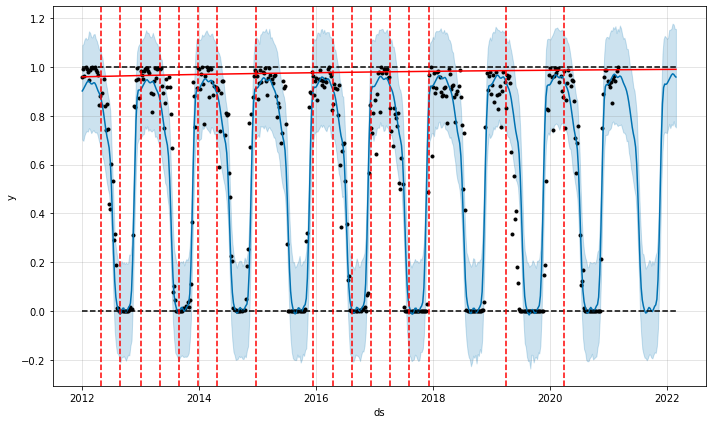

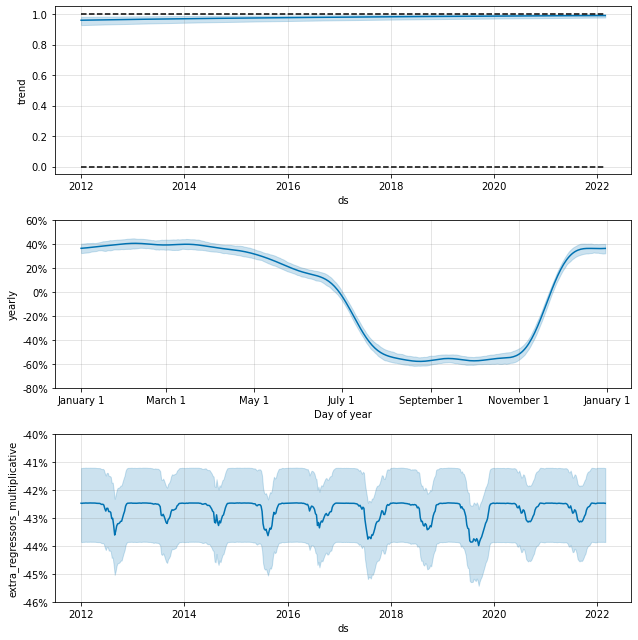

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.083141
std       0.051376
min       0.005283
25%       0.033835
50%       0.101743
75%       0.122462
max       0.162267
Name: rmse, dtype: float64
CPU times: user 43.6 s, sys: 3min 50s, total: 4min 33s
Wall time: 1min 1s


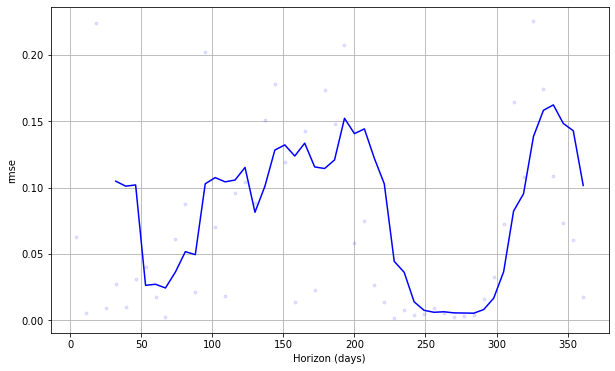

In [229]:
%%time
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    mcmc_samples=100
)
# Add air temp as a regressor
basic.add_regressor('air-temp', standardize=False)
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

##### 500 samples, 43 s, 4 minutes, smoother confidence intervals

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


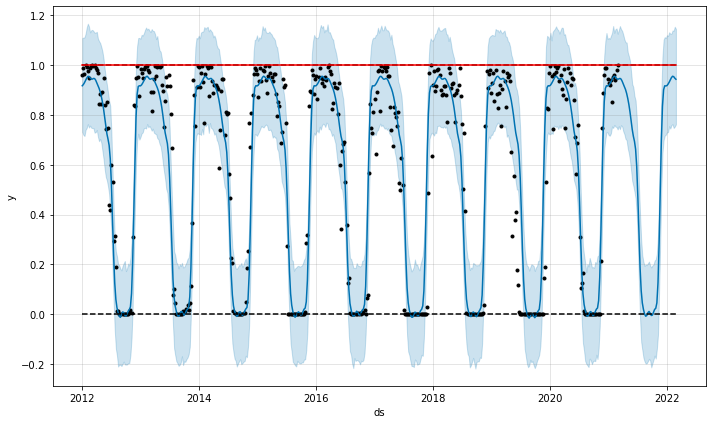

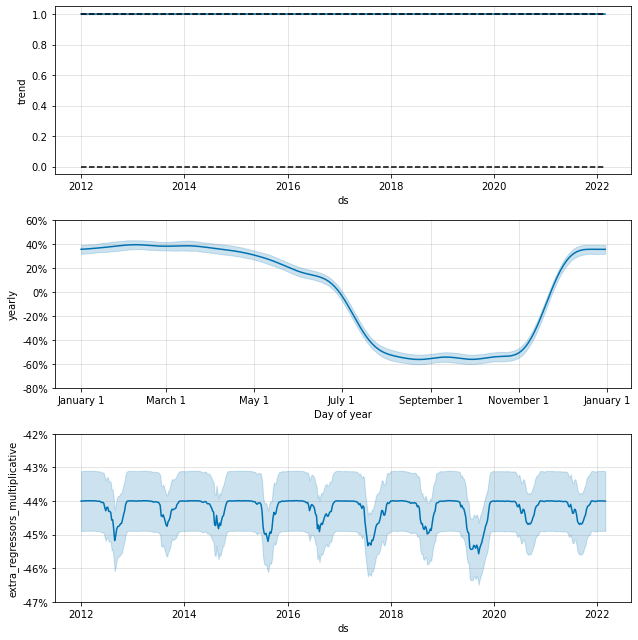

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      5.569668
std       3.854792
min       0.126360
25%       1.020682
50%       7.032100
75%       9.460051
max       9.713259
Name: rmse, dtype: float64
CPU times: user 49.6 s, sys: 4min 16s, total: 5min 6s
Wall time: 4min 23s


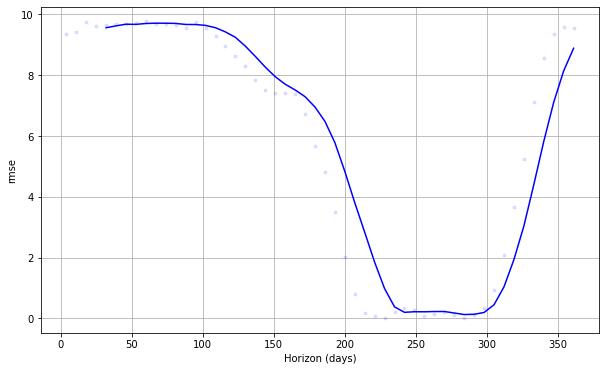

In [231]:
%%time
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    mcmc_samples=500
)
# Add air temp as a regressor
basic.add_regressor('air-temp', standardize=False)
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

## Save Model

In [233]:
import json
from prophet.serialize import model_to_json, model_from_json

with open('serialize-test.json', 'w') as fout:
    json.dump(model_to_json(basic), fout)
    
with open('serialize-test.json') as fin:
    m = model_from_json(json.load(fin))

In [235]:
m == basic

False

In [244]:
np.array_equal(m.params, basic.params)

False

In [247]:
m.params.keys() == basic.params.keys()

True

In [248]:
for key in m.params.keys():
    diff = np.allclose(m.params[key], basic.params[key])
    print(f'{key}: {diff}')

k: True
m: True
delta: True
sigma_obs: True
beta: True
trend: True


## Build model with derivatives

In [58]:
# I should take the derivative in daily values, then take the mean for the week.
# - This is fine for now.
air_dt = np.diff(weekly['air-temp'])
ice_dt = np.diff(weekly['y'])
# add first time step as copy of 1st val in dt
air_dt = np.append(air_dt[0], air_dt)
ice_dt = np.append(ice_dt[0], ice_dt)

air_dt[0] == air_dt[1]

True

In [77]:
weekly['air-dt'] = air_dt
weekly['ice-dt'] = ice_dt

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


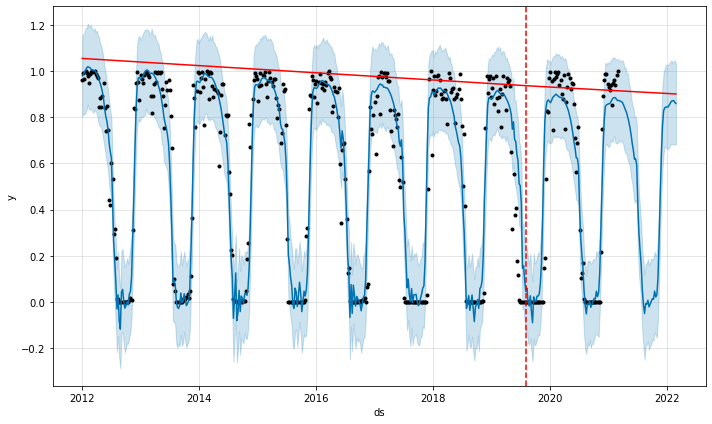

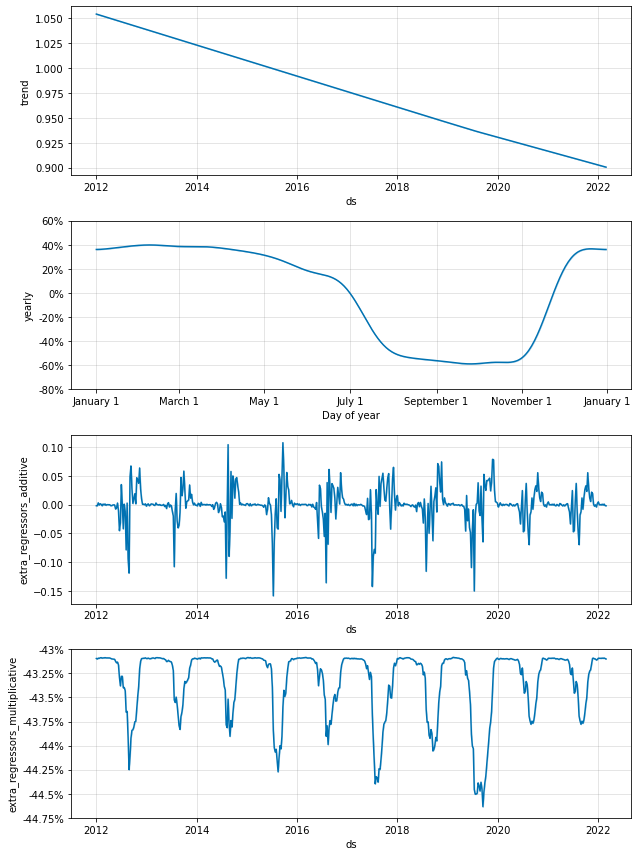

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.130894
std       0.076984
min       0.014386
25%       0.062684
50%       0.137270
75%       0.176851
max       0.264619
Name: rmse, dtype: float64


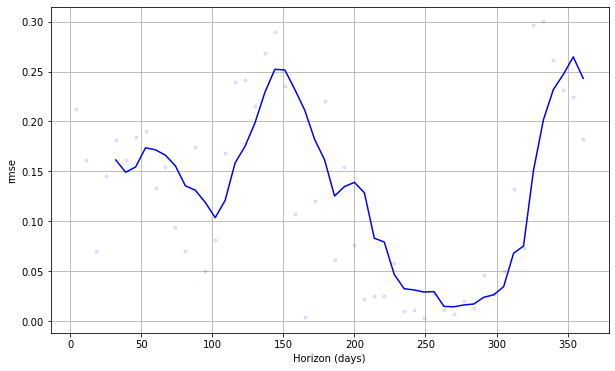

In [74]:
# Same model as Model 2C
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.add_regressor('air-temp', standardize=False)
basic.add_regressor('air-dt', standardize=False, mode='additive')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0

# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp

# copy ait-dt from last year for first attemp
week_future['air-dt'] = weekly['air-dt'].copy()
guess_dt = weekly['air-dt'].iloc[-52::].values.copy()
week_future['air-dt'].iloc[-52::] = guess_dt


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


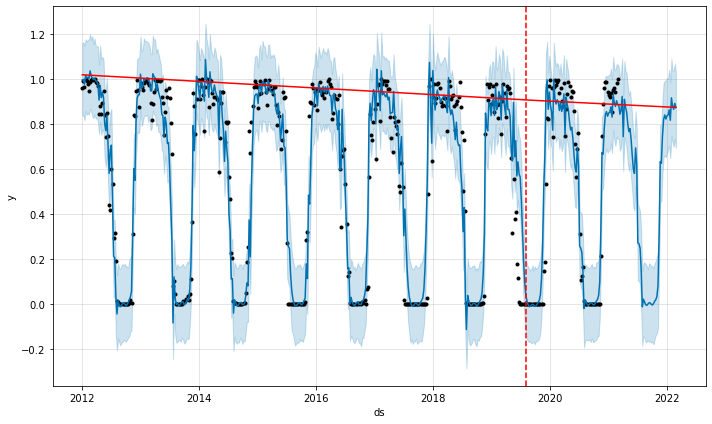

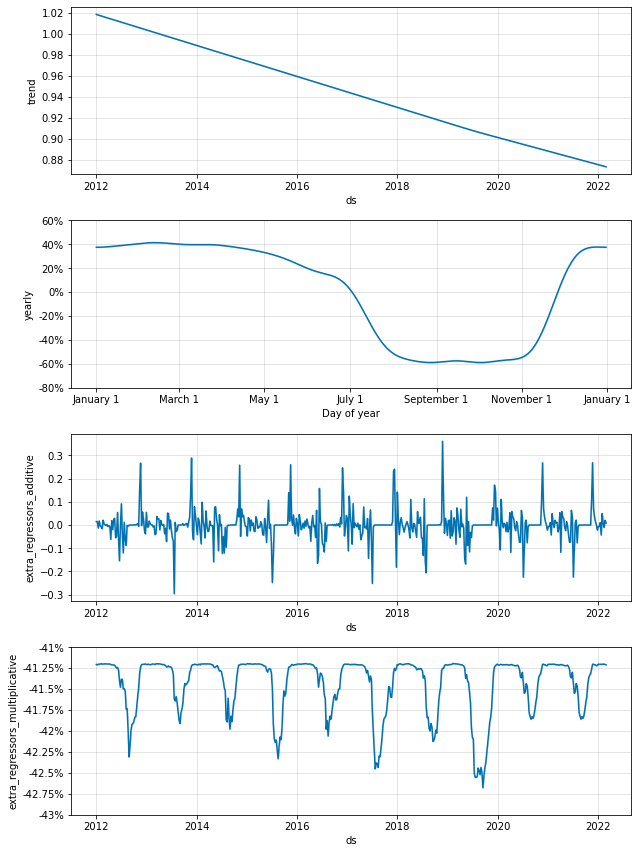

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.123388
std       0.082441
min       0.002118
25%       0.050592
50%       0.132188
75%       0.179036
max       0.264097
Name: rmse, dtype: float64


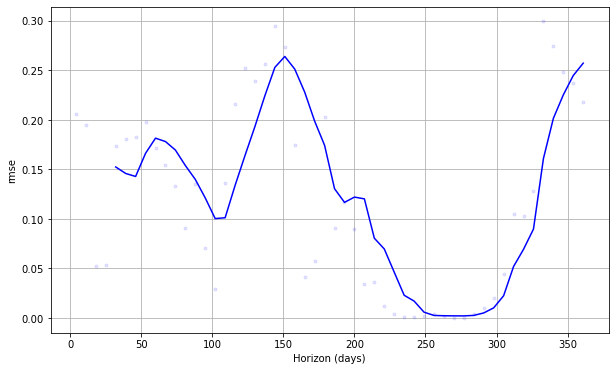

In [78]:
# Same model as Model 2C
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.add_regressor('air-temp', standardize=False)
basic.add_regressor('ice-dt', standardize=False, mode='additive')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0

# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp

# copy ait-dt from last year for first attemp
week_future['air-dt'] = weekly['air-dt'].copy()
guess_dt = weekly['air-dt'].iloc[-52::].values.copy()
week_future['air-dt'].iloc[-52::] = guess_dt

# copy ice-dt from last year for first attemp
week_future['ice-dt'] = weekly['ice-dt'].copy()
guess_dt = weekly['ice-dt'].iloc[-52::].values.copy()
week_future['ice-dt'].iloc[-52::] = guess_dt


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


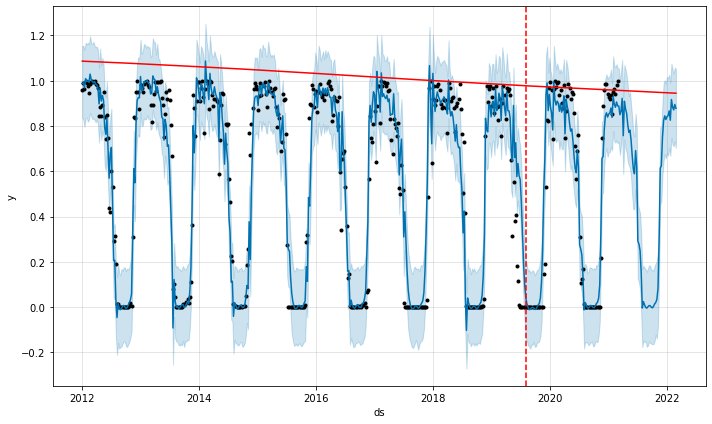

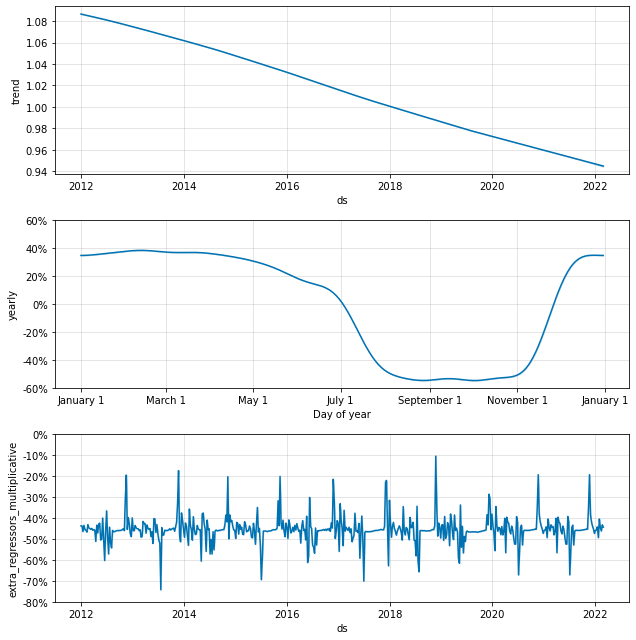

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.119870
std       0.080324
min       0.002164
25%       0.049518
50%       0.125208
75%       0.171419
max       0.255851
Name: rmse, dtype: float64


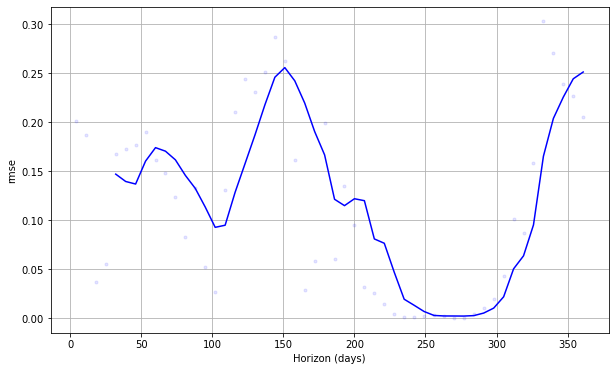

In [79]:
# Same model as Model 2C
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.add_regressor('air-temp', standardize=False)
basic.add_regressor('ice-dt', standardize=False, mode='multiplicative')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0

# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp

# copy ait-dt from last year for first attemp
week_future['air-dt'] = weekly['air-dt'].copy()
guess_dt = weekly['air-dt'].iloc[-52::].values.copy()
week_future['air-dt'].iloc[-52::] = guess_dt

# copy ice-dt from last year for first attemp
week_future['ice-dt'] = weekly['ice-dt'].copy()
guess_dt = weekly['ice-dt'].iloc[-52::].values.copy()
week_future['ice-dt'].iloc[-52::] = guess_dt


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


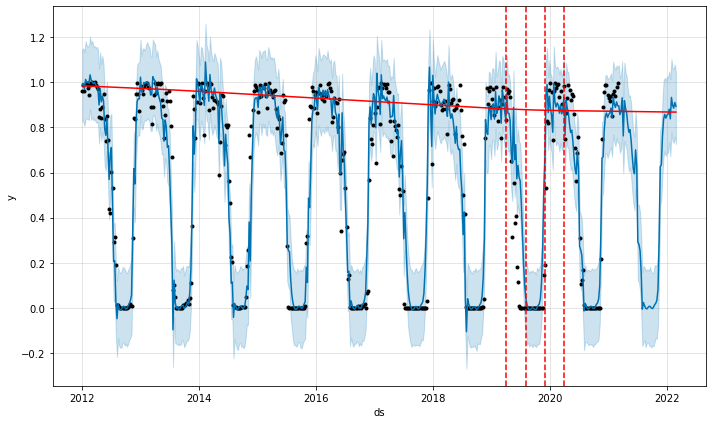

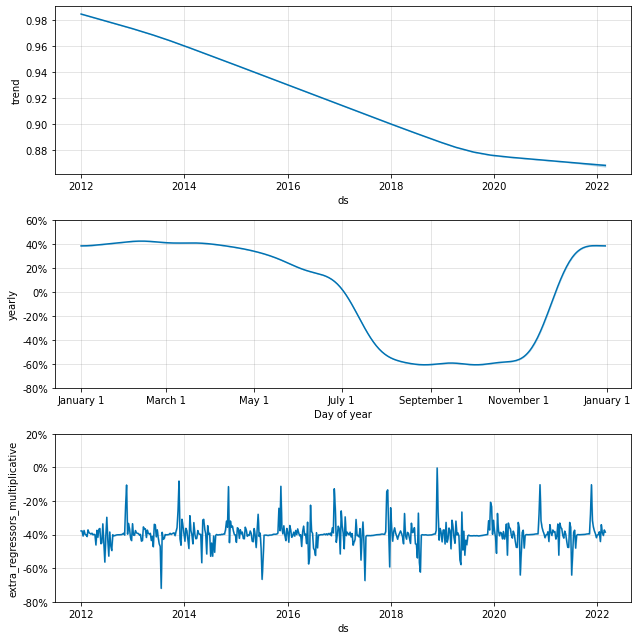

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.125156
std       0.084005
min       0.002164
25%       0.048659
50%       0.132205
75%       0.182302
max       0.264644
Name: rmse, dtype: float64


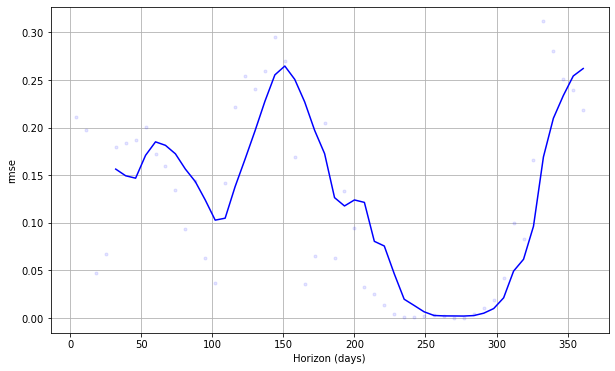

In [80]:
# Same model as Model 2C
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.add_regressor('air-temp', standardize=False)
basic.add_regressor('ice-dt', standardize=True, mode='multiplicative')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0

# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp

# copy ait-dt from last year for first attemp
week_future['air-dt'] = weekly['air-dt'].copy()
guess_dt = weekly['air-dt'].iloc[-52::].values.copy()
week_future['air-dt'].iloc[-52::] = guess_dt

# copy ice-dt from last year for first attemp
week_future['ice-dt'] = weekly['ice-dt'].copy()
guess_dt = weekly['ice-dt'].iloc[-52::].values.copy()
week_future['ice-dt'].iloc[-52::] = guess_dt


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


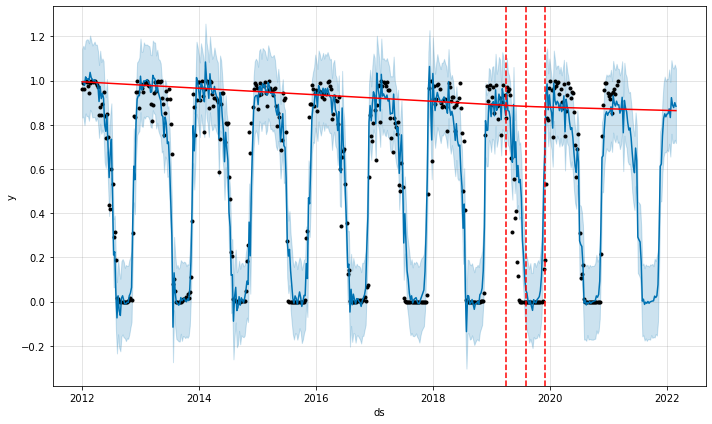

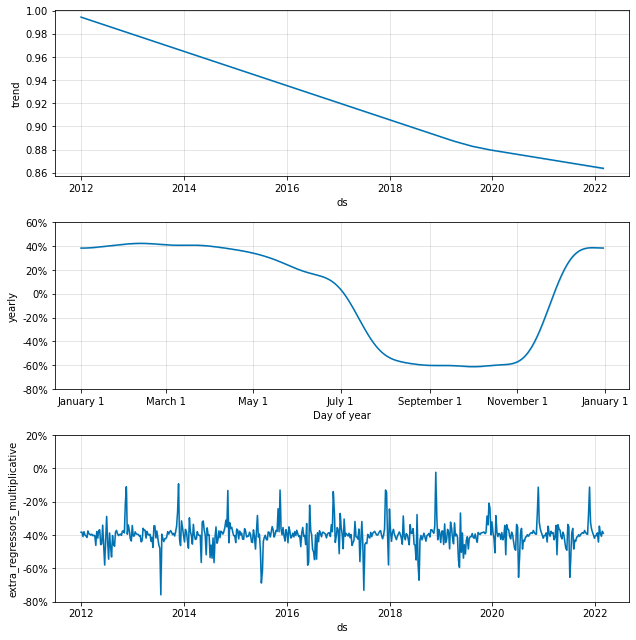

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.125233
std       0.083078
min       0.006199
25%       0.050475
50%       0.130243
75%       0.180868
max       0.263915
Name: rmse, dtype: float64


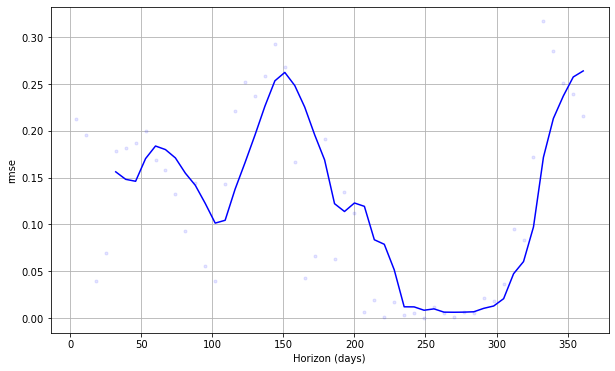

In [81]:
# Same model as Model 2C
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.add_regressor('air-temp', standardize=False)
basic.add_regressor('air-dt', standardize=False, mode='multiplicative')
basic.add_regressor('ice-dt', standardize=True, mode='multiplicative')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0

# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp

# copy ait-dt from last year for first attemp
week_future['air-dt'] = weekly['air-dt'].copy()
guess_dt = weekly['air-dt'].iloc[-52::].values.copy()
week_future['air-dt'].iloc[-52::] = guess_dt

# copy ice-dt from last year for first attemp
week_future['ice-dt'] = weekly['ice-dt'].copy()
guess_dt = weekly['ice-dt'].iloc[-52::].values.copy()
week_future['ice-dt'].iloc[-52::] = guess_dt


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


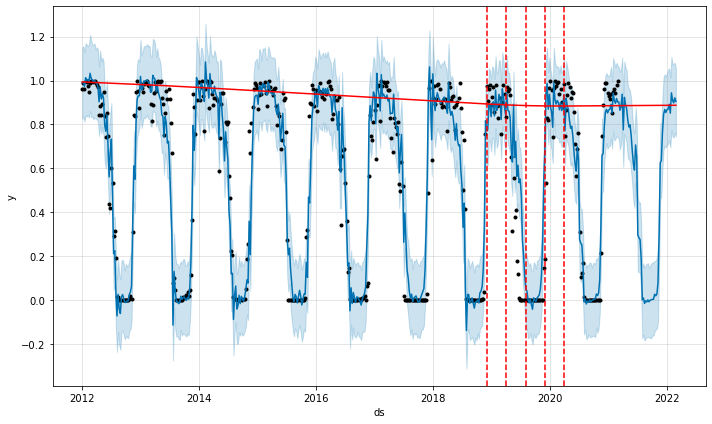

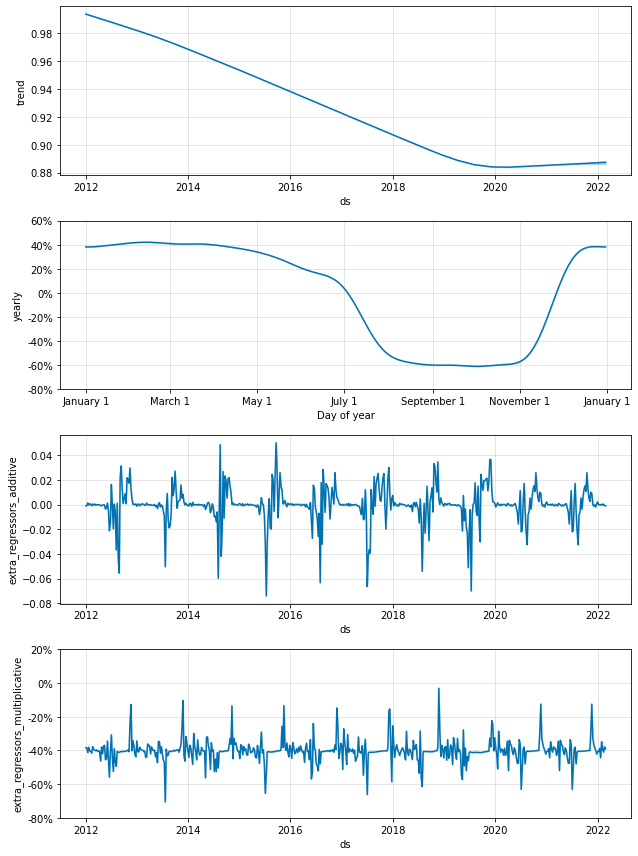

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.123695
std       0.081183
min       0.006362
25%       0.051597
50%       0.127522
75%       0.176781
max       0.260802
Name: rmse, dtype: float64


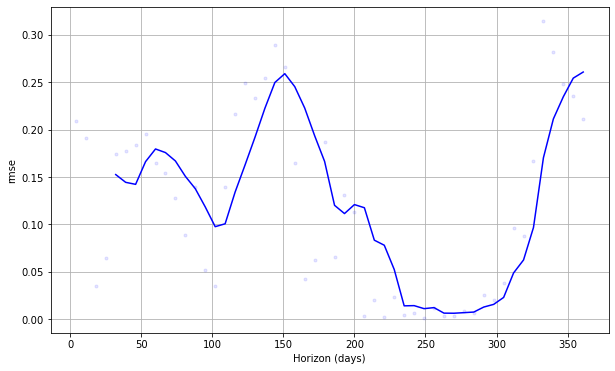

In [82]:
# Same model as Model 2C
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.add_regressor('air-temp', standardize=False)
basic.add_regressor('air-dt', standardize=False, mode='additive')
basic.add_regressor('ice-dt', standardize=True, mode='multiplicative')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0

# copy temp from last year for first attempt of adding
week_future['air-temp'] = weekly['air-temp'].copy()
guess_temp = weekly['air-temp'].iloc[-52::].values.copy()
week_future['air-temp'].iloc[-52::] = guess_temp

# copy ait-dt from last year for first attemp
week_future['air-dt'] = weekly['air-dt'].copy()
guess_dt = weekly['air-dt'].iloc[-52::].values.copy()
week_future['air-dt'].iloc[-52::] = guess_dt

# copy ice-dt from last year for first attemp
week_future['ice-dt'] = weekly['ice-dt'].copy()
guess_dt = weekly['ice-dt'].iloc[-52::].values.copy()
week_future['ice-dt'].iloc[-52::] = guess_dt


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")